# Music Generation

## Local vs Colab Run

If running locally:
-  make a virtual python environment:
`python3 -m venv musicgen `

- activate it:
`source musicgen/bin/activate`

- select that kernel for running this notebook.

- You must also have a `data` folder, if you want to load existing models have a `model_weight` folder

## Import Libraries

In [4]:
!pip install numpy pandas matplotlib scikit-learn pretty_midi torch transformers tqdm jupyter pyfluidsynth x-transformers miditoolkit ipython ipywidgets seaborn soundfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.3 MB/s eta 0:00:00
  

In [5]:
import os
import ast
import math
import time
import torch
import random
import shutil
import pretty_midi
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from torch.serialization import add_safe_globals
from sklearn.decomposition import PCA
from IPython.display import Audio, FileLink, display
import soundfile as sf
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset
from itertools import chain
from collections import Counter
from __future__ import annotations
from typing import Dict, List, TypeVar
from sklearn.preprocessing import MultiLabelBinarizer
from x_transformers import TransformerWrapper, Decoder, AutoregressiveWrapper
from scipy.stats import entropy
from miditoolkit import MidiFile
from ipywidgets import Dropdown, Button, VBox, HBox, Output, Layout, FloatSlider, IntSlider, IntProgress
from IPython.display import display, Audio, FileLink

# for plots
plt.rcParams.update({
    'axes.titlesize': 17,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 17,
})

print("CUDA available?", torch.cuda.is_available())

CUDA available? False


### **Extract and Load Data**

### Determine Environment: Mount Google Drive or Run Locally

In [6]:
try:
    import google.colab
    USE_COLAB = True
except ImportError:
    USE_COLAB = False

if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = Path("/content/drive/MyDrive/ac209b_project")
    print("Running in Colab. Mounted Google Drive.")
else:
    base_dir = Path("/Users/isabelayepes/Desktop/AC209B_data2/musicgenproj/ac209b_project")
    print("Running locally at", base_dir)

Mounted at /content/drive
Running in Colab. Mounted Google Drive.


Next, create a shortcut in Google Drive to `ac209b_project` by right clicking on the folder, clicking Organize > Add shortcut.

### Paths & Copy and Extract Dataset if needed

In [7]:
# Paths
model_weight_dir = base_dir / "model_weight"
model_weight_dir.mkdir(parents=True, exist_ok=True)

df_path = model_weight_dir / "df_training_global.pkl"
tokenizer_path = model_weight_dir / "tokenizer.pkl"
dictionary_path = model_weight_dir / "dictionary.pkl"
flattened_token_path = model_weight_dir / "token_sequences_flattened.pkl"
checkpoint_path = model_weight_dir / "transformer_song_model_650samples.pt"

# Benchmark MIDI output
benchmark_dir = base_dir / "benchmark_generated_midis"
benchmark_dir.mkdir(exist_ok=True, parents=True)

# Directories to sync
audio_drive_dir = base_dir / "audio"  # assumed source of extracted MIDI files

if USE_COLAB:
    # Google Drive paths
    drive_zip_path = base_dir / "data/test/I.zip"
    local_zip_path = Path("/content/I.zip")
    local_extract_dir = Path("/content/test")

    json_drive_path = base_dir / "data/midicaps_train.json"
    json_local_path = Path("/content/midicaps_train.json")

    csv_drive_path = base_dir / "data/merged_midi_data.csv"
    csv_local_path = Path("/content/merged_midi_data.csv")

    audio_local_dir = Path("/content/audio")

    # Copy zip from Drive
    if not local_zip_path.exists():
        print("Copying zip file from Drive...")
        shutil.copy(drive_zip_path, local_zip_path)
    else:
        print("Zip already in session.")

    # Extract zip
    if not local_extract_dir.exists() or len(os.listdir(local_extract_dir)) == 0:
        print("Extracting zip file...")
        local_extract_dir.mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(local_zip_path, local_extract_dir)
    else:
        print("Zip already extracted.")

    # Copy JSON metadata
    if not json_local_path.exists():
        print("Copying JSON metadata...")
        shutil.copy(json_drive_path, json_local_path)

    # Copy CSV if needed
    try:
        if not csv_local_path.exists() and csv_drive_path.exists():
            shutil.copy(csv_drive_path, csv_local_path)
    except Exception as e:
        print(f"Unexpected error while copying CSV: {e}")

else:
    # Local paths
    local_extract_dir = base_dir / "data" / "test"
    json_local_path = base_dir / "data" / "midicaps_train.json"
    csv_local_path = base_dir / "data" / "merged_midi_data.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Colab. Mounted Google Drive.
Copying zip file from Drive...
Extracting zip file...
Copying JSON metadata...


The below checks if the df_training_global can be loaded. If not, it creates it.

In [8]:
# MIDI instrument number -> instrument name mapping (ref: https://fmslogo.sourceforge.io/manual/midi-instrument.html)
GM_PROGRAM_MAP = {
    0: "Acoustic Grand Piano",
    1: "Bright Acoustic Piano",
    2: "Electric Grand Piano",
    3: "Honky-tonk Piano",
    4: "Electric Piano 1",
    5: "Electric Piano 2",
    6: "Harpsichord",
    7: "Clavinet",
    8: "Celesta",
    9: "Glockenspiel",
    10: "Music Box",
    11: "Vibraphone",
    12: "Marimba",
    13: "Xylophone",
    14: "Tubular Bells",
    15: "Dulcimer",
    16: "Drawbar Organ",
    17: "Percussive Organ",
    18: "Rock Organ",
    19: "Church Organ",
    20: "Reed Organ",
    21: "Accordion",
    22: "Harmonica",
    23: "Tango Accordion",
    24: "Acoustic Guitar (nylon)",
    25: "Acoustic Guitar (steel)",
    26: "Electric Guitar (jazz)",
    27: "Electric Guitar (clean)",
    28: "Electric Guitar (muted)",
    29: "Overdriven Guitar",
    30: "Distortion Guitar",
    31: "Guitar Harmonics",
    32: "Acoustic Bass",
    33: "Electric Bass (finger)",
    34: "Electric Bass (pick)",
    35: "Fretless Bass",
    36: "Slap Bass 1",
    37: "Slap Bass 2",
    38: "Synth Bass 1",
    39: "Synth Bass 2",
    40: "Violin",
    41: "Viola",
    42: "Cello",
    43: "Contrabass",
    44: "Tremolo Strings",
    45: "Pizzicato Strings",
    46: "Orchestral Harp",
    47: "Timpani",
    48: "String Ensemble 1",
    49: "String Ensemble 2",
    50: "Synth Strings 1",
    51: "Synth Strings 2",
    52: "Choir Aahs",
    53: "Voice Oohs",
    54: "Synth Voice",
    55: "Orchestra Hit",
    56: "Trumpet",
    57: "Trombone",
    58: "Tuba",
    59: "Muted Trumpet",
    60: "French Horn",
    61: "Brass Section",
    62: "Synth Brass 1",
    63: "Synth Brass 2",
    64: "Soprano Sax",
    65: "Alto Sax",
    66: "Tenor Sax",
    67: "Baritone Sax",
    68: "Oboe",
    69: "English Horn",
    70: "Bassoon",
    71: "Clarinet",
    72: "Piccolo",
    73: "Flute",
    74: "Recorder",
    75: "Pan Flute",
    76: "Blown Bottle",
    77: "Shakuhachi",
    78: "Whistle",
    79: "Ocarina",
    80: "Lead 1 (square)",
    81: "Lead 2 (sawtooth)",
    82: "Lead 3 (calliope)",
    83: "Lead 4 (chiffer)",
    84: "Lead 5 (charang)",
    85: "Lead 6 (voice)",
    86: "Lead 7 (fifths)",
    87: "Lead 8 (bass + lead)",
    88: "Pad 1 (new age)",
    89: "Pad 2 (warm)",
    90: "Pad 3 (polysynth)",
    91: "Pad 4 (choir)",
    92: "Pad 5 (bowed)",
    93: "Pad 6 (metallic)",
    94: "Pad 7 (halo)",
    95: "Pad 8 (sweep)",
    96: "FX 1 (rain)",
    97: "FX 2 (soundtrack)",
    98: "FX 3 (crystal)",
    99: "FX 4 (atmosphere)",
    100: "FX 5 (brightness)",
    101: "FX 6 (goblins)",
    102: "FX 7 (echoes)",
    103: "FX 8 (sci-fi)",
    104: "Sitar",
    105: "Banjo",
    106: "Shamisen",
    107: "Koto",
    108: "Kalimba",
    109: "Bagpipe",
    110: "Fiddle",
    111: "Shanai",
    112: "Tinkle Bell",
    113: "Agogo",
    114: "Steel Drums",
    115: "Woodblock",
    116: "Taiko Drum",
    117: "Melodic Tom",
    118: "Synth Drum",
    119: "Reverse Cymbal",
    120: "Guitar Fret Noise",
    121: "Breath Noise",
    122: "Seashore",
    123: "Bird Tweet",
    124: "Telephone Ring",
    125: "Helicopter",
    126: "Applause",
    127: "Gunshot",
    128: "Drums"
}

Searches recursively through a directory to locate a specific MIDI file based on the filename extracted from a metadata row.

In [9]:
def find_midi_file(row, root_dir="/content/test"):
    """
    Searches for a MIDI file in a specified root directory based on the filename provided in a metadata row.

    Args:
        row (dict): Dictionary containing at least a 'location' field with the filename or path.
        root_dir (str, optional): Directory root to start the search. Defaults to "/content/test".

    Returns:
        str or None: Full path to the found MIDI file, or None if not found.
    """
    filename = os.path.basename(row['location'])
    print(f"Searching for '{filename}' in '{root_dir}'...")

    for current_dir, _, files in os.walk(root_dir):
        if filename in files:
            found_path = os.path.join(current_dir, filename)
            print(f"Found '{filename}' in '{current_dir}' -> {found_path}")
            return found_path
    print(f"'{filename}' not found in '{root_dir}'")
    return None

In [10]:
# STEP 1: Load or generate df_training_global
if os.path.exists(df_path):
    print("Loading cached df_training_global...")
    df_training_global = pd.read_pickle(df_path)
    print(df_training_global.head())
    print(f"Loaded cached df_training_global with {len(df_training_global)} rows from {df_path}")

else:
    print("df_training_global not found. Building full pipeline...")

    # === MIDI Parsing & Metadata Merge ===
    midi_files = [
        os.path.join(dp, f)
        for dp, dn, filenames in os.walk(local_extract_dir)
        for f in filenames
        if f.endswith('.mid') and '/__MACOSX/' not in os.path.join(dp, f) and not f.startswith('._')
    ]
    print(f"Found {len(midi_files)} MIDI files")

    bad_files = []

    def extract_note_stats(midi_file):
        try:
            midi_data = pretty_midi.PrettyMIDI(midi_file)
            note_count = sum(len(inst.notes) for inst in midi_data.instruments)
            duration = midi_data.get_end_time()

            if note_count > 0:
                return {
                    'filename': os.path.basename(midi_file),
                    'num_notes': note_count,
                    'duration_sec': duration,
                    'notes_per_sec': note_count / duration if duration > 0 else 0
                }
            else:
                return None
        except Exception as e:
            bad_files.append((midi_file, str(e)))
            return None

    if os.path.exists(csv_local_path):
        print("Cached CSV found. Loading merged DataFrame...")
        df = pd.read_csv(csv_local_path)
    else:
        print("No cached CSV. Parsing MIDI files and merging with metadata...")
        stats = []

        for i, f in enumerate(midi_files):
            if i % 50 == 0:
                print(f"Processing file {i}/{len(midi_files)}")
            result = extract_note_stats(f)
            if result:
                stats.append(result)

        df_stats = pd.DataFrame(stats)
        print(f"Parsed {len(df_stats)} good files.")
        print(f"Skipped {len(bad_files)} bad files.")
        print(df_stats.head())

        df_caps = pd.read_json(json_local_path, lines=True)
        df_caps['filename'] = df_caps['location'].apply(lambda x: x.split('/')[-1])

        df = pd.merge(df_stats, df_caps, on='filename', how='inner')
        print(f"Merged shape: {df.shape}")
        df.to_csv(csv_local_path, index=False)
        print("Saved merged DataFrame to session CSV.")

        unmatched = df_stats[~df_stats['filename'].isin(df['filename'])]
        print(f"{len(unmatched)} MIDI files had no matching metadata.")

    # Drop redundant/not useful columns, Drop samples with null values in key, tempo, or tempo\_word
    df = df.drop(columns=['duration', 'duration_word', 'test_set'], errors='ignore')
    df = df.dropna(subset=['key', 'tempo', 'tempo_word'])

    # Optional: instrument_counts
    def build_instrument_counts(row):
        try:
            nums = ast.literal_eval(row['instrument_numbers_sorted']) if isinstance(row['instrument_numbers_sorted'], str) else row['instrument_numbers_sorted']
            if not isinstance(nums, list):
                return None
            name_stream = [GM_PROGRAM_MAP.get(int(n), f"Unknown ({n})") for n in nums]
            return dict(Counter(name_stream))
        except:
            return None

    df['instrument_counts'] = df.apply(build_instrument_counts, axis=1)
    print(f"{len(df)} samples in df")

    # === Sampling + fixed paths ===
    df_exploded_genre = df.explode('genre')
    top_5_genres = df_exploded_genre['genre'].value_counts().head(5).index.tolist()

    df_filtered = df_exploded_genre[
        (df_exploded_genre['genre'].isin(top_5_genres)) &
        (df_exploded_genre['duration_sec'] >= 10)
    ].copy()

    global_median_duration = df_filtered['duration_sec'].median()

    selected_dfs_global = []
    for genre in top_5_genres:
        genre_df = df_filtered[df_filtered['genre'] == genre].copy()
        genre_df['duration_diff'] = (genre_df['duration_sec'] - global_median_duration).abs()
        selected_dfs_global.append(genre_df.sort_values('duration_diff').head(650))

    df_training_global = pd.concat(selected_dfs_global).reset_index(drop=True).drop(columns=['duration_diff'])

    # Save df_training_global *without* fixed_location
    df_training_global.to_pickle(df_path)
    print(f"Saved df_training_global to {df_path}")


Loading cached df_training_global...
                               filename  num_notes  duration_sec  \
0  97842e90bcc9a35a155450baec7e7f39.mid       4105    223.540692   
1  6330ea39ad15b2817528d094cda68b32.mid       2488    224.133333   
2  dec8fe41eec9ae7b1f30f13c3c55ad03.mid       3055    223.435161   
3  704c180839d9e593a23cc8b17f3c352a.mid       3055    223.435161   
4  5bc04a7a9652413628930e88e4b19790.mid       3606    223.364992   

   notes_per_sec                                         location  \
0      18.363547  lmd_full/9/97842e90bcc9a35a155450baec7e7f39.mid   
1      11.100535  lmd_full/6/6330ea39ad15b2817528d094cda68b32.mid   
2      13.672870  lmd_full/d/dec8fe41eec9ae7b1f30f13c3c55ad03.mid   
3      13.672870  lmd_full/7/704c180839d9e593a23cc8b17f3c352a.mid   
4      16.143980  lmd_full/5/5bc04a7a9652413628930e88e4b19790.mid   

                                             caption            genre  \
0  A joyful pop Christmas song featuring electric...  ['pop', 'roc

### After loading `df_training_global` cache
##### Adds fixed location based on colab vs local

In [11]:
# Reload df_training_global and update fixed_location paths
df_training_global['fixed_location'] = df_training_global.apply(
    lambda row: find_midi_file(row, root_dir=local_extract_dir), axis=1
)

# To validate that paths are correct after adding fixed_location
print("Fixed paths exist:", df_training_global['fixed_location'].map(lambda x: Path(x).exists()).value_counts())

Searching for '97842e90bcc9a35a155450baec7e7f39.mid' in '/content/test'...
Found '97842e90bcc9a35a155450baec7e7f39.mid' in '/content/test/I/J/T/TRIJTPP128F42375E5' -> /content/test/I/J/T/TRIJTPP128F42375E5/97842e90bcc9a35a155450baec7e7f39.mid
Searching for '6330ea39ad15b2817528d094cda68b32.mid' in '/content/test'...
Found '6330ea39ad15b2817528d094cda68b32.mid' in '/content/test/I/S/O/TRISOHH128F931B31C' -> /content/test/I/S/O/TRISOHH128F931B31C/6330ea39ad15b2817528d094cda68b32.mid
Searching for 'dec8fe41eec9ae7b1f30f13c3c55ad03.mid' in '/content/test'...
Found 'dec8fe41eec9ae7b1f30f13c3c55ad03.mid' in '/content/test/I/B/I/TRIBIEW128F9324458' -> /content/test/I/B/I/TRIBIEW128F9324458/dec8fe41eec9ae7b1f30f13c3c55ad03.mid
Searching for '704c180839d9e593a23cc8b17f3c352a.mid' in '/content/test'...
Found '704c180839d9e593a23cc8b17f3c352a.mid' in '/content/test/I/B/I/TRIBIEW128F9324458' -> /content/test/I/B/I/TRIBIEW128F9324458/704c180839d9e593a23cc8b17f3c352a.mid
Searching for '5bc04a7a96524

---

## **Data Inspection of Cleaned Training Dataset**

### Inspect Columns

In [12]:
print("Column names:")
df_training_global.columns.tolist()

Column names:


['filename',
 'num_notes',
 'duration_sec',
 'notes_per_sec',
 'location',
 'caption',
 'genre',
 'genre_prob',
 'mood',
 'mood_prob',
 'key',
 'time_signature',
 'tempo',
 'tempo_word',
 'chord_summary',
 'chord_summary_occurence',
 'instrument_summary',
 'instrument_numbers_sorted',
 'all_chords',
 'all_chords_timestamps',
 'instrument_counts',
 'fixed_location']

### Sample Rows from the DataFrame

In [13]:
df_training_global.head()

filename  num_notes  duration_sec  \
0  97842e90bcc9a35a155450baec7e7f39.mid       4105    223.540692   
1  6330ea39ad15b2817528d094cda68b32.mid       2488    224.133333   
2  dec8fe41eec9ae7b1f30f13c3c55ad03.mid       3055    223.435161   
3  704c180839d9e593a23cc8b17f3c352a.mid       3055    223.435161   
4  5bc04a7a9652413628930e88e4b19790.mid       3606    223.364992   

   notes_per_sec                                         location  \
0      18.363547  lmd_full/9/97842e90bcc9a35a155450baec7e7f39.mid   
1      11.100535  lmd_full/6/6330ea39ad15b2817528d094cda68b32.mid   
2      13.672870  lmd_full/d/dec8fe41eec9ae7b1f30f13c3c55ad03.mid   
3      13.672870  lmd_full/7/704c180839d9e593a23cc8b17f3c352a.mid   
4      16.143980  lmd_full/5/5bc04a7a9652413628930e88e4b19790.mid   

                                             caption            genre  \
0  A joyful pop Christmas song featuring electric...  ['pop', 'rock']   
1  A slow and melodic pop song in D major, featur...  ['pop', 'rock']   
2  A slow-paced pop song with a touch of rock, fe...  ['pop', 'rock']   
3  A melodic pop rock song with a Christmas vibe,...  ['pop', 'rock']   
4  A slow-paced pop Christmas song in F major, fe...  ['pop', 'rock']   

                                   genre_prob  \
0               [0.5439, 0.18910000000000002]   
1               [0.36920000000000003, 0.2172]   
2  [0.40950000000000003, 0.24710000000000001]   
3               [0.4173, 0.26830000000000004]   
4                            [0.3435, 0.2018]   

                                                mood  \
0  ['happy', 'christmas', 'love', 'melodic', 'pos...   
1  ['melodic', 'happy', 'love', 'christmas', 'rel...   
2  ['melodic', 'christmas', 'love', 'happy', 'bal...   
3  ['melodic', 'love', 'christmas', 'happy', 'bal...   
4  ['christmas', 'melodic', 'love', 'happy', 'bal...   

                                           mood_prob  ...  tempo tempo_word  \
0  [0.20370000000000002, 0.09630000000000001, 0.0...  ...  124.0       Fast   
1  [0.0848, 0.0843, 0.08410000000000001, 0.0806, ...  ...   75.0       Slow   
2  [0.14070000000000002, 0.1058, 0.08990000000000...  ...   72.0       Slow   
3             [0.13, 0.0944, 0.0892, 0.0844, 0.0709]  ...   72.0    Andante   
4              [0.136, 0.0971, 0.084, 0.0792, 0.062]  ...   80.0       Slow   

                      chord_summary chord_summary_occurence  \
0              ['B', 'E', 'A', 'E']                       9   
1  ['D', 'A/C#', 'Bm7', 'A', 'Em7']                       4   
2         ['A', 'E', 'D', 'A', 'E']                       7   
3         ['A', 'E', 'D', 'A', 'E']                       7   
4                  ['Bb/F', 'Eb/F']                       6   

                                  instrument_summary  \
0  ['Electric Guitar', 'Piano', 'Acoustic Guitar'...   
1  ['Piano', 'Choir Aahs', 'Alto Saxophone', 'Str...   
2  ['Rock Organ', 'Drums', 'Acoustic Guitar', 'El...   
3  ['Rock Organ', 'Drums', 'Acoustic Guitar', 'El...   
4  ['Piano', 'Distortion Guitar', 'String Ensembl...   

                           instrument_numbers_sorted  \
0                           [26, 26, 0, 25, 128, 32]   
1  [0, 52, 65, 48, 35, 128, 56, 44, 96, 17, 71, 7...   
2              [18, 128, 25, 33, 29, 29, 25, 25, 25]   
3              [18, 128, 25, 33, 29, 29, 25, 25, 25]   
4               [0, 30, 48, 35, 46, 128, 52, 24, 68]   

                                          all_chords  \
0  ['E', 'B7', 'E', 'A/E', 'E', 'B', 'E', 'A', 'E...   
1  ['D', 'Em', 'F#m7', 'A', 'D', 'Em', 'D', 'G', ...   
2  ['A', 'E', 'D', 'E', 'F#m7', 'E7', 'A', 'E', '...   
3  ['A', 'E', 'D', 'E', 'F#m7', 'E7', 'A', 'E', '...   
4  ['F', 'Bb', 'Eb', 'Adim', 'Bb', 'F', 'Eb/Bb', ...   

                               all_chords_timestamps  \
0  [0.464399092, 7.801904761, 9.659501133, 15.603...   
1  [0.464399092, 1.3931972780000001, 3.065034013,...   
2  [0.464399092, 13.281814058, 16.625487528, 19.9...   
3  [0.464399092, 13.374693877, 16.625487528, 19

### Missing Values

In [14]:
print("\nSummary of missing values:")
df_training_global.isnull().sum()


Summary of missing values:


filename                     0
num_notes                    0
duration_sec                 0
notes_per_sec                0
location                     0
caption                      0
genre                        0
genre_prob                   0
mood                         0
mood_prob                    0
key                          0
time_signature               0
tempo                        0
tempo_word                   0
chord_summary                0
chord_summary_occurence      0
instrument_summary           0
instrument_numbers_sorted    0
all_chords                   0
all_chords_timestamps        0
instrument_counts            0
fixed_location               0
dtype: int64

### Data Types

In [15]:
print("\nData types:")
df_training_global.dtypes


Data types:


filename                      object
num_notes                      int64
duration_sec                 float64
notes_per_sec                float64
location                      object
caption                       object
genre                         object
genre_prob                    object
mood                          object
mood_prob                     object
key                           object
time_signature                object
tempo                        float64
tempo_word                    object
chord_summary                 object
chord_summary_occurence        int64
instrument_summary            object
instrument_numbers_sorted     object
all_chords                    object
all_chords_timestamps         object
instrument_counts             object
fixed_location                object
dtype: object

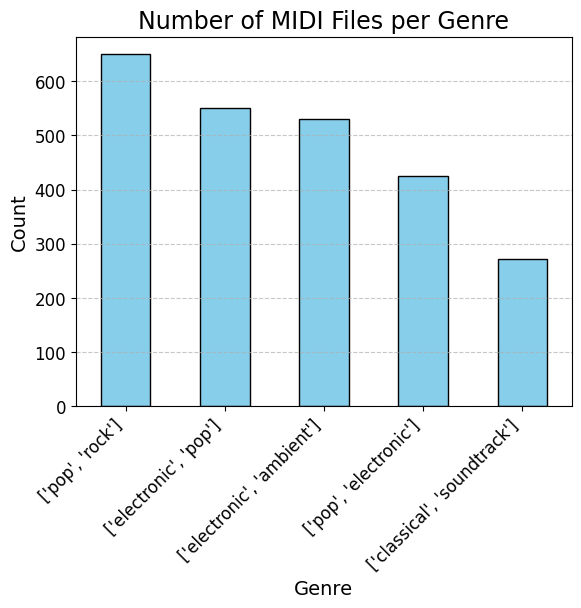

In [16]:
# Plot the bar plot for df_training_global["genre"]
genre_counts = df_training_global["genre"].value_counts()
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of MIDI Files per Genre")
plt.ylabel("Count")
plt.xlabel("Genre")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---

The cleaned dataset retains the following columns, each of which is relevant for either musical structure, genre/mood classification, or caption-based modeling:

- `filename`: Unique name of the MIDI file
- `num_notes`: Total number of note events in the MIDI file
- `duration_sec`: Total duration of the piece in seconds
- `notes_per_sec`: Density of notes over time (can be used to identify sparse or very dense pieces)
- `caption`: Textual description of the music (from the MidiCaps dataset), useful for aligning text and symbolic music
- `genre`: List of genre labels associated with the piece (multi-label)
- `mood`: List of mood descriptors (multi-label)
- `key`: The musical key (e.g., C major, A minor) — useful for tonal analysis
- `time_signature`: The time signature (e.g., 4/4, 6/8) — relevant for rhythmic modeling
- `tempo`: Estimated tempo in beats per minute (BPM)
- `tempo_word`: A qualitative description of tempo (e.g., "Allegro", "Moderate")
- `chord_summary`: Summary of the main chords used in the piece
- `chord_summary_occurence`: Number of distinct chord changes in the summary
- `instrument_summary`: List of instruments used in the piece
- `instrument_numbers_sorted`: MIDI program numbers representing the instruments used
- `instrument_counts`: Dictionary with instrument name as the keys and the count as the values

These features provide a well-rounded view of each song, spanning symbolic structure, genre/mood classification, instrument arrangement, and human-interpretable captions — all of which support downstream tasks like music generation, genre classification, or text-to-music alignment.

## **Baseline Model**

The insights from exploratory data analysis (EDA) directly informed the choice of model architecture and conditioning strategy through genre token injection in the Transformer input.
Our baseline model for symbolic music generation uses a decoder-only Transformer architecture. The model is composed of 12 decoder layers, each with 8 attention heads and an embedding dimension of 512, wrapped in an AutoregressiveWrapper for causal, next-token prediction.

The model is trained on token sequences derived from a custom tokenizer that encodes MIDI files using genre tags, quantized time shifts, and note pitches.
These sequences are padded or truncated to a maximum length of 512 tokens (plus optional prompt during generation) and clamped to a predefined vocabulary size.

Training is performed using cross-entropy loss and the Adam optimizer.
Mini-batches are sampled randomly, with gradient accumulation and anomaly detection used to ensure stable training, even in the presence of rare numerical instabilities.

Music generation is performed by predicting one token at a time, optionally conditioned on a genre prompt token.
Sampling uses a temperature parameter to control randomness.
Generated token sequences are then detokenized back into MIDI files by reversing the time and note encoding.

The overall pipeline supports genre-conditioned generation and MIDI reconstruction, with evaluation based on validation loss and qualitative listening of generated outputs.

### Dictionary Class for Token Mapping

Defines a simple helper class `Dictionary` that manages the mapping between musical event tokens and their corresponding word forms.
This class abstracts the operations of converting between tokenized sequences and readable musical events, and vice-versa.
It is a critical component for both generation (converting words to tokens) and decoding (reconstructing music from tokens).

In [17]:
class Dictionary(object):
    """
    Helper class to manage mappings between musical words (events) and integer token IDs.

    Attributes:
        wtd (dict): Mapping from word (musical event) to token ID.
        dtw (dict): Mapping from token ID to word (musical event).

    Methods:
        word_to_data(word): Returns the token ID corresponding to a given word.
        data_to_word(data): Returns the word corresponding to a given token ID.
        size(): Returns the number of unique entries in the dictionary.
    """

    def __init__(self, word_to_data, data_to_word):
        """
        Initialize the Dictionary with mappings from words to tokens and tokens to words.

        Args:
            word_to_data (dict): Dictionary mapping words to token IDs.
            data_to_word (dict): Dictionary mapping token IDs to words.
        """
        self.wtd = word_to_data
        self.dtw = data_to_word

    def word_to_data(self, word):
        """
        Convert a word (musical event) to its corresponding token ID.

        Args:
            word (str): The musical word or event to be converted.

        Returns:
            int: Token ID corresponding to the input word.
        """
        return self.wtd[word]

    def data_to_word(self, data):
        """
        Convert a token ID back to its corresponding word (musical event).

        Args:
            data (int): The token ID to be converted.

        Returns:
            str: Word (musical event) corresponding to the input token ID.
        """
        return self.dtw[data]

    def size(self):
        """
        Return the size of the dictionary, i.e., the number of unique words/events.

        Returns:
            int: Number of entries in the word-to-token mapping.
        """
        return len(self.wtd)

Provides a set of helper functions for managing devices, padding sequences, batch preparation, and safe dictionary lookups, used throughout the training and inference pipelines

In [18]:
TKey = TypeVar('TKey')
TValue = TypeVar('TValue')

def get_device() -> torch.device:
    """
    Returns the appropriate device for computation.

    Checks if a CUDA-compatible GPU is available and returns the appropriate
    `torch.device` object, otherwise defaults to CPU.

    Returns:
        torch.device: The device to be used for computation ('cuda:0' or 'cpu').
    """
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def pad(array: np.ndarray, max_sequence_length: int, padding_character: int = 0) -> np.ndarray:
    """
    Pads a NumPy array to a specified maximum sequence length.

    If the array is shorter than the target length, it pads with a specified character (default 0).
    If the array is longer, it truncates it to the maximum length.

    Args:
        array (np.ndarray): The array to pad or truncate.
        max_sequence_length (int): Desired final length of the array.
        padding_character (int, optional): Character to pad with. Defaults to 0.

    Returns:
        np.ndarray: The padded or truncated array.
    """
    if len(array) >= max_sequence_length:
        return array[:max_sequence_length]
    else:
        number_of_padding_tokens_to_add = max_sequence_length - len(array)
        return np.pad(array, (0, number_of_padding_tokens_to_add), 'constant', constant_values=padding_character)

def get_full_batch(training_data, batch_size, device, sequence_length=513, vocab_size=None):
    """
    Generates a full training batch from the given training data.

    Randomly selects sequences from the training dataset, pads or truncates
    them to a fixed sequence length, moves them to the specified device,
    and clamps the values to a vocabulary size if provided.

    Args:
        training_data (List[List[int]]): Tokenized training data.
        batch_size (int): Number of sequences in the batch.
        device (torch.device): Device to move the batch to ('cuda' or 'cpu').
        sequence_length (int, optional): Fixed length for each sequence. Defaults to 513.
        vocab_size (int, optional): If provided, clamps token values to [0, vocab_size].

    Returns:
        torch.Tensor: Batch tensor of shape (batch_size, sequence_length).
    """
    indices = random.choices(range(len(training_data)), k=batch_size)
    batch_list = []
    for i in indices:
        seq = training_data[i]
        if len(seq) < sequence_length:
            seq = seq + [0] * (sequence_length - len(seq))
        elif len(seq) > sequence_length:
            seq = seq[:sequence_length]
        batch_list.append(seq)
    batch_tensor = torch.tensor(batch_list).long().to(device)
    if vocab_size is not None:
        batch_tensor = torch.clamp(batch_tensor, min=0, max=vocab_size)
    print("Generated batch shape:", batch_tensor.shape, "min:", batch_tensor.min().cpu().item(), "max:", batch_tensor.max().item())
    return batch_tensor

def get_or_default(dictionary: Dict[TKey, TValue], key: TKey, defaults: Dict[TKey, TValue]) -> TValue:
    """
    Safely retrieves a value from a dictionary, falling back to a default if the key is missing.

    Args:
        dictionary (Dict[TKey, TValue]): Primary dictionary to search.
        key (TKey): Key to retrieve.
        defaults (Dict[TKey, TValue]): Dictionary of default values.

    Returns:
        TValue: The value from the primary dictionary if available; otherwise, the default value.
    """
    return dictionary[key] if key in dictionary else defaults[key]

### TransformerModel Class for Symbolic Music Generation

Defines a flexible and reusable Transformer model wrapper for symbolic music generation tasks.
Supports training, sampling, saving, loading, and model customization through parameterization.

In [19]:
class TransformerModel(object):
    """
    A wrapper class for a decoder-only Transformer model designed for symbolic music generation.

    Provides utilities for training, generation, checkpoint saving/loading, and device management.

    Attributes:
        dictionary (Dictionary): Token-to-word and word-to-token mapping dictionary.
        max_sequence_length (int): Maximum sequence length for input sequences.
        learning_rate (float): Learning rate for the optimizer.
        dropout (float): Dropout rate applied in the Transformer layers.
        dim (int): Embedding dimension.
        depth (int): Number of Transformer decoder layers.
        heads (int): Number of attention heads.
        device (torch.device): Computation device (CPU or GPU).
        model (torch.nn.Module): Wrapped Transformer model.
        optimizer (torch.optim.Optimizer): Optimizer used for training.
    """

    def __init__(self,
                 dictionary,
                 max_sequence_length=512,
                 learning_rate=1e-4,
                 dropout=0.1,
                 dim=512,
                 depth=12,
                 heads=8):
        """
        Initializes the TransformerModel with specified hyperparameters.

        Args:
            dictionary (Dictionary): Token dictionary.
            max_sequence_length (int, optional): Maximum sequence length. Defaults to 512.
            learning_rate (float, optional): Learning rate. Defaults to 1e-4.
            dropout (float, optional): Dropout rate. Defaults to 0.1.
            dim (int, optional): Embedding dimension. Defaults to 512.
            depth (int, optional): Number of decoder layers. Defaults to 12.
            heads (int, optional): Number of attention heads. Defaults to 8.
        """
        self.dictionary = dictionary
        self.learning_rate = learning_rate
        self.max_sequence_length = max_sequence_length
        self.dropout = dropout
        self.dim = dim
        self.depth = depth
        self.heads = heads

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.create_model().to(self.device)
        self.optimizer = self.create_optimizer()

    def set_learning_rate(self, learning_rate):
        """
        Updates the learning rate and reinitializes the optimizer.

        Args:
            learning_rate (float): New learning rate value.
        """
        self.learning_rate = learning_rate
        self.optimizer = self.create_optimizer()

    def train(self, x_train, epochs, batch_size=4, stop_loss=None,
              batches_per_epoch=100, report_per_x_batches=20, gradient_accumulation_steps=1):
        """
        Trains the Transformer model on the given dataset.

        Args:
            x_train (List[List[int]]): Training data as token sequences.
            epochs (int): Number of training epochs.
            batch_size (int, optional): Batch size. Defaults to 4.
            stop_loss (float, optional): Early stopping threshold on loss. Defaults to None.
            batches_per_epoch (int, optional): Number of batches per epoch. Defaults to 100.
            report_per_x_batches (int, optional): Print status after this many batches. Defaults to 20.
            gradient_accumulation_steps (int, optional): Number of steps to accumulate gradients. Defaults to 1.
        """
        self.model.train()
        start_time = time.time()
        for epoch in range(epochs):
            print(f"Training epoch {epoch + 1}.")
            epoch_losses = []
            batch_losses = []
            nr_of_batches_processed = 0

            for batch_idx in range(batches_per_epoch):
                for _ in range(gradient_accumulation_steps):
                    batch = self.get_batch(x_train, batch_size)
                    torch_batch = torch.tensor(batch).long().to(self.device)

                    print(f"Before clamping, batch {batch_idx}: shape {torch_batch.shape}, "
                          f"min {torch_batch.min().cpu().item()}, max {torch_batch.max().cpu().item()}")

                    clamped_batch = torch.clamp(torch_batch, min=0, max=self.dictionary.size())

                    print(f"After clamping, batch {batch_idx}: "
                          f"min {clamped_batch.min().cpu().item()}, max {clamped_batch.max().cpu().item()}")


                    with torch.autograd.detect_anomaly():
                        loss = self.model(clamped_batch)
                        loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                self.optimizer.step()
                self.optimizer.zero_grad()

                nr_of_batches_processed += 1
                loss_item = loss.item()
                batch_losses.append(loss_item)
                epoch_losses.append(loss_item)

                if nr_of_batches_processed % report_per_x_batches == 0:
                    print(f"Processed {nr_of_batches_processed} / {batches_per_epoch} batches, current average loss: {np.mean(batch_losses):.4f}")
                    batch_losses = []

            epoch_loss = np.mean(epoch_losses)
            running_time = (time.time() - start_time)
            print(f"Loss after epoch {epoch + 1} is {epoch_loss:.4f}. Running time: {running_time:.2f} seconds")

            if stop_loss is not None and epoch_loss <= stop_loss:
                print(f"Loss {epoch_loss:.4f} is lower than stop loss {stop_loss}. Stopping training.")
                return

    def generate(self, output_length=100, temperature=1., prompt=None):
        """
        Generates a new token sequence conditioned on an optional prompt.

        Args:
            output_length (int, optional): Number of tokens to generate. Defaults to 100.
            temperature (float, optional): Sampling temperature. Defaults to 1.0.
            prompt (List[int], optional): Prompt token sequence. Defaults to [0].

        Returns:
            np.ndarray: Generated token sequence.
        """
        print(f"Generating a new song with {output_length} characters.")
        if prompt is None:
            prompt = [0]

        self.model.eval()
        initial = torch.tensor([prompt]).long().to(self.device)
        sample = self.model.generate(initial, output_length, temperature=temperature)
        return sample.cpu().detach().numpy()[0]

    def create_model(self):
        """
        Creates the underlying Transformer model.

        Returns:
            torch.nn.Module: The initialized Transformer model wrapped for autoregressive prediction.
        """
        return AutoregressiveWrapper(
            TransformerWrapper(
                num_tokens=self.dictionary.size()+1,
                max_seq_len=self.max_sequence_length,
                attn_layers=Decoder(
                    dim=self.dim,
                    depth=self.depth,
                    heads=self.heads,
                    attn_dropout=self.dropout,
                    ff_dropout=self.dropout,
                    rotary_pos_emb=False
                )
            ),
            ignore_index=0,
            pad_value=0
        )

    def create_optimizer(self):
        """
        Creates the Adam optimizer with the current learning rate.

        Returns:
            torch.optim.Adam: The Adam optimizer instance.
        """
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def save_checkpoint(self, path):
        """
        Saves the model and optimizer states to a checkpoint file.

        Args:
            path (str): Path to save the checkpoint.
        """
        print(f'Saving checkpoint to {path}')
        torch.save({
            'dictionary': self.dictionary,
            'max_sequence_length': self.max_sequence_length,
            'learning_rate': self.learning_rate,
            'dropout': self.dropout,
            'dim': self.dim,
            'depth': self.depth,
            'heads': self.heads,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)

    @staticmethod
    def load_checkpoint(path):
        """
        Loads a TransformerModel from a checkpoint file.

        Args:
            path (str): Path to the checkpoint file.

        Returns:
            TransformerModel: Loaded TransformerModel instance.
        """
        checkpoint = torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        model = TransformerModel(
            dictionary=checkpoint['dictionary'],
            max_sequence_length=checkpoint.get('max_sequence_length', 512),
            learning_rate=checkpoint.get('learning_rate', 1e-4),
            dropout=checkpoint.get('dropout', 0.1),
            dim=checkpoint.get('dim', 512),
            depth=checkpoint.get('depth', 12),
            heads=checkpoint.get('heads', 8)
        )
        model.model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        return model

    def get_batch(self, data, batch_size):
        """
        Samples a random batch of sequences from the training data.

        Args:
            data (List[List[int]]): List of token sequences.
            batch_size (int): Size of the batch.

        Returns:
            List[List[int]]: Sampled batch of token sequences.
        """
        indices = np.random.choice(len(data), batch_size)
        return [data[i][:self.max_sequence_length] for i in indices]

In [20]:
def tokenize_midi(midi_file, metadata=None, quantization_factor=0.05):
    pm = pretty_midi.PrettyMIDI(midi_file)
    # --- parse genres robustly ---
    raw = (metadata or {}).get("genre", [])
    if isinstance(raw, str):
        try:
            parsed = ast.literal_eval(raw)
            raw = parsed if isinstance(parsed, list) else [raw]
        except:
            raw = [raw]
    genres = raw

    # --- collect events per instrument, preserving identity, velocity, duration ---
    events = []
    for inst in pm.instruments:
        prog = inst.program
        drum_flag = inst.is_drum
        events.append((inst, f"INSTR_{prog}{'_DRUM' if drum_flag else ''}"))

    # flatten & sort by start time
    timed_events = []
    for inst, inst_token in events:
        for note in inst.notes:
            timed_events.append((note.start, inst_token, note))
    timed_events.sort(key=lambda x: x[0])

    tokens = []
    prev_t = 0.0
    for start, inst_token, note in timed_events:
        # time shift
        gap = start - prev_t
        steps = int(round(gap / quantization_factor))
        if steps > 0:
            tokens.append(f"TIME_SHIFT_{steps}")
        # instrument switch (if it changed)
        if not tokens or tokens[-1] != inst_token:
            tokens.append(inst_token)
        # velocity
        vel_bin = note.velocity // 16   # 0–7
        tokens.append(f"VELOCITY_{vel_bin}")
        # note on + duration
        tokens.append(f"NOTE_ON_{note.pitch}")
        dur_steps = int(round((note.end - note.start) / quantization_factor))
        tokens.append(f"DURATION_{dur_steps}")
        prev_t = start

    # prepend genre conditioning
    if genres:
        out = []
        for g in genres:
            out.append([f"GENRE_{g.upper()}"] + tokens)
        return out
    else:
        return [tokens]

In [21]:
def build_vocabulary(token_lists):
    """
    Builds a vocabulary from a list of token lists, *including* special tokens
    for padding, unknowns, BOS, and EOS.

    Args:
        token_lists (List[List[str]]): All token sequences.

    Returns:
        Dictionary: A mapping between tokens and indices.
    """
    # 1) Define special tokens
    specials = ["<PAD>", "<UNK>", "<BOS>", "<EOS>"]

    # 2) Build the set of all tokens in your data
    vocab = set(token for seq in token_lists for token in seq)

    # 3) Sort tokens for reproducibility, then enumerate *after* the specials
    ordered = sorted(vocab)
    token_to_idx = {tok: i for i, tok in enumerate(specials)}
    base_index = len(specials)
    for idx, tok in enumerate(ordered, start=base_index):
        token_to_idx[tok] = idx

    # 4) Build the inverse map
    idx_to_token = {idx: tok for tok, idx in token_to_idx.items()}

    return Dictionary(token_to_idx, idx_to_token)


Reconstructs a MIDI file from a tokenized musical event sequence. Handles note placement and time shifts based on previously tokenized information, reversing the tokenization process

In [22]:
def detokenize_to_midi(tokens, quantization_factor=0.05, output_midi_path="out.mid"):
    midi = pretty_midi.PrettyMIDI()
    instruments = {}
    current_prog = 0
    current_vel  = 100
    current_time = 0.0
    pending_pitch = None

    for tok in tokens:
        # 1) Skip genre / special tokens
        if tok.startswith("GENRE_") or tok in ("<PAD>", "<UNK>", "<BOS>"):
            continue
        if tok == "<EOS>":
            break

        # 2) TIME_SHIFT
        if tok.startswith("TIME_SHIFT_"):
            steps = int(tok[len("TIME_SHIFT_"):])
            current_time += steps * quantization_factor
            continue

        # 3) INSTR_ token (handle _DRUM)
        if tok.startswith("INSTR_"):
            suffix = tok[len("INSTR_"):]                  # e.g. "0" or "0_DRUM"
            parts = suffix.split("_")                     # ["0"] or ["0", "DRUM"]
            prog = int(parts[0])
            is_drum = "DRUM" in parts

            if prog not in instruments:
                instruments[prog] = pretty_midi.Instrument(program=prog, is_drum=is_drum)
            current_prog = prog
            continue

        # 4) VELOCITY
        if tok.startswith("VELOCITY_"):
            bin = int(tok[len("VELOCITY_"):])
            current_vel = bin * 16 + 8
            continue

        # 5) NOTE_ON
        if tok.startswith("NOTE_ON_"):
            pending_pitch = int(tok[len("NOTE_ON_"):])
            continue

        # 6) DURATION → emit note
        if tok.startswith("DURATION_") and pending_pitch is not None:
            dur_steps = int(tok[len("DURATION_"):])
            end_time = current_time + dur_steps * quantization_factor

            # Ensure current_prog is valid
            if current_prog not in instruments:
                instruments[current_prog] = pretty_midi.Instrument(program=current_prog)

            note = pretty_midi.Note(
                velocity=current_vel,
                pitch=pending_pitch,
                start=current_time,
                end=end_time
            )
            instruments[current_prog].notes.append(note)
            pending_pitch = None
            continue

    # 7) Finalize
    for inst in instruments.values():
        midi.instruments.append(inst)
    midi.write(output_midi_path)
    print(f"Wrote {output_midi_path}")

### MusicDataset Class for Symbolic Music Token Sequences
A PyTorch Dataset wrapper for tokenized MIDI sequences,
enabling efficient loading, padding, and batching for Transformer training.

In [23]:
class MusicDataset(Dataset):
    """
    A custom PyTorch Dataset for loading tokenized MIDI sequences.

    Converts token sequences into padded tensors suitable for
    Transformer-based training, handling truncation, padding,
    unknown tokens, and attention masks automatically.
    """

    def __init__(self, token_sequences, dictionary, max_sequence_length=512):
        """
        Initializes the MusicDataset.

        Args:
            token_sequences (List[List[str]]): List of tokenized MIDI sequences.
            dictionary (Dictionary): Vocabulary object mapping tokens to indices.
            max_sequence_length (int, optional): Maximum sequence length for
                padding/truncation. Defaults to 512.
        """
        self.dictionary = dictionary
        self.max_sequence_length = max_sequence_length

        # Index of the <UNK> token, for any out-of-vocab items
        self.unk_idx = self.dictionary.wtd.get("<UNK>", 1)

        # Convert token strings to integer IDs, mapping OOV to <UNK>
        self.sequences = [
            [self.dictionary.wtd.get(tok, self.unk_idx) for tok in seq]
            for seq in token_sequences
        ]

    def __len__(self):
        """Returns the number of sequences in the dataset."""
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Retrieves a padded and tensorized sequence by index,
        along with its attention mask.

        Returns:
            dict with:
                - 'input_ids': LongTensor of shape (max_sequence_length,)
                - 'attention_mask': LongTensor of shape (max_sequence_length,)
        """
        seq = self.sequences[idx]
        seq_len = min(len(seq), self.max_sequence_length)

        # Truncate or pad the sequence
        if seq_len < self.max_sequence_length:
            padded = seq + [self.dictionary.wtd["<PAD>"]] * (self.max_sequence_length - seq_len)
        else:
            padded = seq[: self.max_sequence_length]

        input_ids = torch.tensor(padded, dtype=torch.long)

        # 1 where there's real token, 0 where there's padding
        attention_mask = torch.arange(self.max_sequence_length) < seq_len
        attention_mask = attention_mask.long()

        return torch.tensor(padded, dtype=torch.long)

        # return {
        #     "input_ids": input_ids,
        #     "attention_mask": attention_mask
        # }

In [24]:
# Tokenizer caching
if os.path.exists(tokenizer_path):
    print("Loading cached token_sequences...")
    with open(tokenizer_path, "rb") as f:
        token_sequences = pickle.load(f)
    print(f"Loaded {len(token_sequences)} sequences from {tokenizer_path}")
else:
    print("Generating token_sequences...")
    token_sequences = []
    for idx, row in df_training_global.iterrows():
        if row['fixed_location'] is None:
            print(f"Skipping {row['location']} because fixed_location not found.")
            continue
        tokens = tokenize_midi(row['fixed_location'], metadata=row.to_dict(), quantization_factor=0.05)
        if tokens:
            token_sequences.append(tokens)
        else:
            print(f"Warning: No tokens generated for {row['fixed_location']}")
    print(f"Tokenization complete. Processed {len(token_sequences)} token sequences.")
    with open(tokenizer_path, "wb") as f:
        pickle.dump(token_sequences, f)
    print(f"Saved tokenizer to {tokenizer_path}")

for seq in token_sequences[:10]:
    print(seq[:10])

if os.path.exists(dictionary_path) and os.path.exists(flattened_token_path):
    print("Loading cached dictionary and flattened token sequences...")
    with open(dictionary_path, "rb") as f:
        dictionary = pickle.load(f)
    with open(flattened_token_path, "rb") as f:
        token_sequences = pickle.load(f)
else:
    print("Flattening and building dictionary from token_sequences...")
    token_sequences = [seq for genre_group in token_sequences for seq in genre_group]
    with open(flattened_token_path, "wb") as f:
        pickle.dump(token_sequences, f)
    print(f"Saved flattened token sequences to {flattened_token_path}")

    dictionary = build_vocabulary(token_sequences)
    with open(dictionary_path, "wb") as f:
        pickle.dump(dictionary, f)
    print(f"Dictionary saved to {dictionary_path}")

print("Vocabulary size (excluding padding):", dictionary.size())

Loading cached token_sequences...
Loaded 2428 sequences from /content/drive/MyDrive/ac209b_project/Model Weight/tokenizer.pkl
[['GENRE_POP', 'TIME_SHIFT_77', 'INSTR_32', 'VELOCITY_6', 'NOTE_ON_40', 'DURATION_12', 'INSTR_0', 'VELOCITY_4', 'NOTE_ON_52', 'DURATION_17', 'INSTR_25', 'VELOCITY_4', 'NOTE_ON_52', 'DURATION_28', 'INSTR_0_DRUM', 'VELOCITY_7', 'NOTE_ON_42', 'DURATION_2', 'INSTR_0_DRUM', 'VELOCITY_7', 'NOTE_ON_35', 'DURATION_2', 'TIME_SHIFT_6', 'INSTR_0_DRUM', 'VELOCITY_5', 'NOTE_ON_42', 'DURATION_2', 'TIME_SHIFT_3', 'INSTR_0', 'VELOCITY_4', 'NOTE_ON_59', 'DURATION_8', 'INSTR_0', 'VELOCITY_4', 'NOTE_ON_68', 'DURATION_8', 'INSTR_25', 'VELOCITY_7', 'NOTE_ON_59', 'DURATION_19', 'INSTR_25', 'VELOCITY_5', 'NOTE_ON_64', 'DURATION_19', 'INSTR_0_DRUM', 'VELOCITY_7', 'NOTE_ON_37', 'DURATION_2', 'INSTR_0_DRUM', 'VELOCITY_7', 'NOTE_ON_42', 'DURATION_2', 'TIME_SHIFT_6', 'INSTR_0_DRUM', 'VELOCITY_5', 'NOTE_ON_42', 'DURATION_2', 'TIME_SHIFT_3', 'INSTR_32', 'VELOCITY_6', 'NOTE_ON_35', 'DURATION_

In [25]:
max_seq_length = 513
dataset = MusicDataset(token_sequences, dictionary, max_sequence_length=max_seq_length)
print(f"Created MusicDataset with {len(dataset)} sequences.")

Created MusicDataset with 4856 sequences.


In [26]:
training_data = [seq.tolist() for seq in dataset]

Scans the tokenized training data to find the maximum token index used,
and compares it against the dictionary vocabulary size to ensure consistency and proper token clamping during training.

In [27]:
max_index = 0
for seq in training_data:
    if len(seq) > 0:
        current_max = max(seq)
        if current_max > max_index:
            max_index = current_max
print("Maximum index in training data:", max_index)
print("Vocabulary size (allowed indices 1 to):", dictionary.size())

Maximum index in training data: 1117
Vocabulary size (allowed indices 1 to): 1118


In [28]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Using GPU:", torch.cuda.is_available())

Using GPU: False


### Training Transformer Model on Tokenized MIDI Data

##### Trains Transformer if Cache not Present, otherwise loads cache from saved checkpoint

If cache not present: Configures batch size and calculates the number of batches per epoch based on the training dataset size.
Trains the Transformer model for multiple epochs using the full tokenized MIDI subset, printing loss after each batch.

If cahce is present: Restores the Transformer model and optimizer states from a saved checkpoint file.
Enables immediate evaluation, fine-tuning, or generation without retraining the model

In [29]:
# Make sure class definitions are globally available before loading
add_safe_globals([Dictionary, TransformerModel])

if os.path.exists(checkpoint_path):
    print(f"Checkpoint found at {checkpoint_path}. Loading model...")

    ckpt = torch.load(checkpoint_path, map_location='cpu',
    weights_only=False
                      )

    transformer2 = TransformerModel(
        dictionary=ckpt['dictionary'],
        max_sequence_length=ckpt['max_sequence_length'],
        learning_rate=ckpt['learning_rate'],
        dropout=ckpt['dropout'],
        dim=ckpt['dim'],
        depth=ckpt['depth'],
        heads=ckpt['heads']
    )
    transformer2.model.load_state_dict(ckpt['model_state_dict'])
    transformer2.optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    transformer2.model.eval()
    print("Loaded checkpoint; model is ready to generate or fine-tune.")

else:
    print("No checkpoint found. Initializing and training model...")

    transformer = TransformerModel(
        dictionary,
        max_sequence_length=max_seq_length,
        learning_rate=1e-4,
        dropout=0.1,
        dim=512,
        depth=6,
        heads=8
    )

    transformer.get_batch = lambda x_train, bs: get_full_batch(
        x_train, bs, transformer.device,
        sequence_length=max_seq_length,
        vocab_size=dictionary.size()
    )

    batch_size = 32
    batches_per_epoch = math.ceil(len(training_data) / batch_size)
    print("Batches per epoch:", batches_per_epoch)
    print("Starting training on the entire subset (full batch mode)")
    transformer.train(
        training_data,
        epochs=10,
        batch_size=batch_size,
        batches_per_epoch=batches_per_epoch,
        report_per_x_batches=1
    )
    print("Training complete on the entire subset.")
    # Saves the trained Transformer model and optimizer states into a checkpoint file,
    transformer.save_checkpoint(checkpoint_path)
    print(f"Model checkpoint saved to {checkpoint_path}")


Checkpoint found at /content/drive/MyDrive/ac209b_project/Model Weight/transformer_song_model_650samples.pt. Loading model...
Loaded checkpoint; model is ready to generate or fine-tune.


Converts a sequence of decoded tokens back into a pretty_midi.PrettyMIDI object,
enabling easy playback, editing, or saving to a MIDI file.

In [30]:
def convert_decoded_tokens_to_pretty_midi(decoded_tokens,
                                          quantization_factor=0.05):
    """
    Converts a decoded token sequence into a pretty_midi.PrettyMIDI object,
    handling instruments (with optional _DRUM suffix), velocities, durations,
    and time shifts.
    """
    midi = pretty_midi.PrettyMIDI()
    instruments   = {}
    current_prog  = 0
    current_vel   = 100
    t             = 0.0
    pending_pitch = None

    for tok in decoded_tokens:
        # Skip genre & specials
        if tok.startswith("GENRE_") or tok in ("<PAD>", "<UNK>", "<BOS>"):
            continue
        if tok == "<EOS>":
            break

        # TIME_SHIFT
        if tok.startswith("TIME_SHIFT_"):
            steps = int(tok.split("_")[-1])
            t += steps * quantization_factor
            continue

        # INSTRUMENT SWITCH (handle "_DRUM" properly)
        if tok.startswith("INSTR_"):
            suffix = tok[len("INSTR_"):]              # e.g., "35" or "35_DRUM"
            parts = suffix.split("_")                 # ["35"] or ["35", "DRUM"]
            prog = int(parts[0])
            is_drum = "DRUM" in parts

            if prog not in instruments:
                instruments[prog] = pretty_midi.Instrument(program=prog, is_drum=is_drum)
            current_prog = prog
            continue

        # VELOCITY
        if tok.startswith("VELOCITY_"):
            b = int(tok.split("_")[-1])
            current_vel = b * 16 + 8
            continue

        # NOTE_ON
        if tok.startswith("NOTE_ON_"):
            pending_pitch = int(tok.split("_")[-1])
            continue

        # DURATION → emit note
        if tok.startswith("DURATION_") and pending_pitch is not None:
            d = int(tok.split("_")[-1])
            end_t = t + d * quantization_factor

            if current_prog not in instruments:
                instruments[current_prog] = pretty_midi.Instrument(program=current_prog)

            note = pretty_midi.Note(
                velocity=current_vel,
                pitch=pending_pitch,
                start=t,
                end=end_t
            )
            instruments[current_prog].notes.append(note)
            pending_pitch = None
            continue

    # finalize all tracks
    for inst in instruments.values():
        midi.instruments.append(inst)

    return midi

Decodes a sequence of token indices into musical events, reconstructs a MIDI object, and saves it to a specified output path.

In [31]:
def decode_tokens_to_midi(tokens, output_path, quantization_factor=0.05):
    """
    Decodes a list of token indices into a MIDI file.

    Maps token indices to musical event strings using the dictionary,
    reconstructs a pretty_midi.PrettyMIDI object, and saves it to the specified location.

    Args:
        tokens (List[int]): List of token indices to decode.
        output_path (str or Path): Destination path to save the generated MIDI file.
        quantization_factor (float, optional): Time resolution factor used for time shifts. Defaults to 0.05.

    Returns:
        None
    """
    decoded = [dictionary.dtw[idx] for idx in tokens if idx != 0]
    midi_obj = convert_decoded_tokens_to_pretty_midi(decoded, quantization_factor)
    midi_obj.write(str(output_path))
    print(f"→ saved {output_path}")

### Genre-Conditioned Music Generation
Generates a new music sequence conditioned on a specified genre token,
decodes the generated tokens into musical events, and reconstructs a MIDI file for listening or evaluation.

In [32]:
specified_genre = "soundtrack"
genre_token = f"GENRE_{specified_genre.upper()}"

if genre_token in dictionary.wtd:
    prompt = [dictionary.wtd[genre_token]]
    print(f"Using prompt token for genre '{specified_genre}': {prompt}")
else:
    prompt = [dictionary.wtd.get("<UNK>", 1)]
    print(f"Genre token '{genre_token}' not found, using <UNK> → {prompt}")

output_length = 400
temperature   = 0.5

# Ensure model is in eval mode
transformer2.model.eval()
with torch.no_grad():
    generated_indices = transformer2.generate(
        prompt         = prompt,
        output_length  = output_length,
        temperature    = temperature
    )

print("Generated indices:", generated_indices)

# --- 3) Decode and write to MIDI ---

output_midi_path = f"generated_music_{specified_genre}.mid"
decode_tokens_to_midi(
    generated_indices,
    output_path         = output_midi_path,
    quantization_factor = 0.05
)
print(f"Generated music saved as '{output_midi_path}'")

Using prompt token for genre 'soundtrack': [623]
Generating a new song with 400 characters.
Generated indices: [ 728 1113  841  368 1003  761 1117  841  227 1087  749 1117  881  355
  749 1117  881  355  741 1117  881  355 1042  749 1117  881  355  749
 1117  881  355  741 1117  888  344  749 1117  888  548  749 1117  888
  553  749 1117  888  548  749 1117  888  344  749 1117  888  548  741
 1117  881  153  741 1117  888  153  749 1117  888  153  749 1117  888
  153  741 1117  888  153  741 1117  888  153  749 1117  888  153  749
 1117  888  153  749 1117  888  153  741 1117  888  153  741 1117  888
  153  741 1117  888  153  741 1117  888  153  749 1117  888  153  749
 1117  888  153  741 1117  888  153  749 1117  888  153  741 1117  888
  153  741 1117  888  153  749 1117  888  153  741 1117  881  153  741
 1117  888  153  749 1117  888  153  741 1117  888  153  741 1117  888
  153  749 1117  888  153  741 1117  888  153  741 1117  893  153  741
 1117  888  153  749 1117  888  153  

## **Real vs. Generated MIDI Benchmarking and Evaluation**

In this section, we benchmark the Transformer model's ability to generate classical music by comparing real and generated MIDI samples. First, we filter the dataset to select real classical MIDI files based on their genre labels. We extract musical features from each real MIDI, including duration, number of notes, and note density (notes per second). Next, we generate an equal number of new classical MIDI samples conditioned on the "classical" genre token, and extract the same features from the generated files. We then summarize and report the mean and standard deviation of these features for both real and generated datasets. To visually assess the similarity between distributions, we plot overlaid histograms comparing the note densities. Finally, we quantitatively evaluate the divergence between real and generated distributions by computing the Kullback-Leibler (KL) divergence, providing a numeric measure of how closely the model replicates real classical music characteristics.

In [33]:
def extract_features_from_midi(midi_file, quantization_factor=0.05):
    """
    Extracts musical features including polyphony from a MIDI file.
    """
    try:
        pm = pretty_midi.PrettyMIDI(str(midi_file))
        duration = pm.get_end_time()
        if duration == 0:
            return None

        notes = []
        for instr in pm.instruments:
            notes.extend(instr.notes)


        if not notes:
            return None

        num_notes = len(notes)
        density = num_notes / duration if duration > 0 else 0.0

        # Pitch Class Histogram
        pitch_classes = np.array([note.pitch % 12 for note in notes])
        pitch_hist, _ = np.histogram(pitch_classes, bins=np.arange(13), density=True)

        # Time Shift Histogram
        notes_sorted = sorted(notes, key=lambda n: n.start)
        time_shifts = np.diff([note.start for note in notes_sorted])
        if len(time_shifts) > 0:
            shift_hist, _ = np.histogram(time_shifts, bins=10, range=(0, 1), density=True)
        else:
            shift_hist = np.zeros(10)

        # Polyphony Calculation
        # Step through all unique time points where notes start or end
        events = []
        for note in notes:
            events.append((note.start, 1))   # note on
            events.append((note.end, -1))    # note off

        events.sort()  # sort by time
        active_notes = 0
        total_active = 0
        last_time = 0.0

        for time, change in events:
            duration_segment = time - last_time
            if duration_segment > 0:
                total_active += active_notes * duration_segment
            active_notes += change
            last_time = time

        avg_polyphony = total_active / duration if duration > 0 else 0.0

        feature_vector = {
            "duration_sec": duration,
            "num_notes": num_notes, # plots are usually empty so removed from histogram
            "notes_per_sec": density,
            "avg_polyphony": avg_polyphony,
            "pitch_histogram": pitch_hist.tolist(),  # 12 values
            "time_shift_histogram": shift_hist.tolist()  # 10 values
        }
        return feature_vector

    except Exception as e:
        print(f"  ✗ failed to load {midi_file}: {e}")
        return None

In [34]:
def compute_frechet_distance(real_feats, gen_feats, normalize=True):
    """
    Computes Fréchet Distance between two sets of feature dictionaries.
    Optionally normalizes features to zero mean and unit variance.
    """
    def flatten_features(f):
        return [
            f["duration_sec"],
            f["num_notes"],
            f["notes_per_sec"],
            f["avg_polyphony"],
            *f["pitch_histogram"],
            *f["time_shift_histogram"],
        ]

    real_mat = np.array([flatten_features(f) for f in real_feats])
    gen_mat  = np.array([flatten_features(f) for f in gen_feats])

    if normalize:
        # Normalize jointly
        combined = np.vstack([real_mat, gen_mat])
        mean = combined.mean(axis=0)
        std = combined.std(axis=0) + 1e-8  # avoid divide by zero
        real_mat = (real_mat - mean) / std
        gen_mat  = (gen_mat  - mean) / std

    mu_r = np.mean(real_mat, axis=0)
    mu_g = np.mean(gen_mat, axis=0)

    sigma_r = np.cov(real_mat, rowvar=False)
    sigma_g = np.cov(gen_mat, rowvar=False)

    covmean, _ = sqrtm(sigma_r.dot(sigma_g), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    diff = mu_r - mu_g
    frechet_dist = np.sum(diff**2) + np.trace(sigma_r + sigma_g - 2*covmean)

    return frechet_dist

In [35]:
def evaluate_genres(
    dictionary,
    transformer,
    features_to_plot,
    quantization_factor=0.05,
    max_samples=70,
    n_gen_samples=30,
    n_repeats=3,
    df=None,
    base_dir=None,
    regenerate=False
):
    assert df is not None, "You must provide a DataFrame with real MIDI metadata."
    assert base_dir is not None, "You must provide a base_dir for saving outputs."

    def is_valid_feature(feat_dict):
        values = np.array([
            feat_dict["duration_sec"],
            feat_dict["notes_per_sec"],
            feat_dict["avg_polyphony"],
            *feat_dict["pitch_histogram"],
            *feat_dict["time_shift_histogram"]
        ])
        return np.all(np.isfinite(values))

    # List all genres available in the subset
    all_genres = []
    for row in df.itertuples():
        raw = getattr(row, "genre", None)
        if isinstance(raw, str):
            try:
                genres = ast.literal_eval(raw)
            except:
                genres = []
            all_genres.extend(genres)

    unique_genres = sorted(set(all_genres))
    print(f"Total genres found: {len(unique_genres)}")
    print(unique_genres)

    genre_counts = Counter(all_genres)
    filtered_genres = [g for g in unique_genres if genre_counts[g] >= max_samples]
    print(f"Filtered genres (>= {max_samples} examples): {filtered_genres}")

    kl_scores = []
    frechet_scores = []

    gen_midi_dir = base_dir / "gen_midi"
    gen_midi_dir.mkdir(parents=True, exist_ok=True)

    for genre in filtered_genres:
        print(f"\n=== Processing Genre: {genre} ===")

        def has_genre(row):
            raw = row.get("genre")
            if isinstance(raw, str):
                try:
                    raw = ast.literal_eval(raw)
                except:
                    raw = []
            return genre in raw

        genre_df = df[df.apply(has_genre, axis=1)].dropna(subset=["fixed_location"])
        n_real_total = len(genre_df)
        n = min(n_real_total, max_samples)
        genre_df = genre_df.sample(n=n, random_state=42).reset_index(drop=True)
        print(f"Using {n} real '{genre}' examples out of {n_real_total} available.")

        if n == 0:
            kl_scores.append(np.nan)
            frechet_scores.append(np.nan)
            continue

        real_features = []
        for _, row in genre_df.iterrows():
            feats = extract_features_from_midi(row["fixed_location"], quantization_factor)
            if feats and is_valid_feature(feats):
                real_features.append(feats)

        genre_token = f"GENRE_{genre}"
        prompt = [dictionary.wtd.get(genre_token, 0)]

        gen_features = []
        for i in range(n):
            out_path = gen_midi_dir / f"{genre}_gen_{i}.mid"
            if regenerate or not out_path.exists():
                idxs = transformer.generate(output_length=60, temperature=1.0, prompt=prompt)
                toks = [dictionary.dtw[i] for i in idxs if i != 0]
                detokenize_to_midi(toks, quantization_factor=quantization_factor, output_midi_path=str(out_path))

            feats = extract_features_from_midi(out_path, quantization_factor=quantization_factor)
            if feats and is_valid_feature(feats):
                gen_features.append(feats)

        print(f"Kept {len(real_features)} real, {len(gen_features)} generated after NaN filtering.")

        real_density = [f["notes_per_sec"] for f in real_features]
        gen_density  = [f["notes_per_sec"] for f in gen_features]

        if len(real_density) == 0 or len(gen_density) == 0:
            print(f"Skipping genre {genre} due to invalid features.")
            kl_scores.append(np.nan)
            frechet_scores.append(np.nan)
            continue

        r_hist, bins = np.histogram(real_density, bins=20, density=True)
        g_hist, _    = np.histogram(gen_density, bins=bins, density=True)
        r_hist += 1e-8
        g_hist += 1e-8
        r_hist /= r_hist.sum()
        g_hist /= g_hist.sum()

        kl = entropy(r_hist, g_hist)
        kl_scores.append(kl)
        print(f"=> {genre}: KL Divergence = {kl:.4f}")

        fd = compute_frechet_distance(real_features, gen_features, normalize=True)
        frechet_scores.append(fd)
        print(f"=> {genre}: Frechet Distance = {fd:.4f}")

        n_features = len(features_to_plot)
        ncols = 2 if n_features > 1 else 1
        nrows = (n_features + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
        axes = np.array(axes).flatten()

        for idx, feature_name in enumerate(features_to_plot):
            real_vals = [f[feature_name] for f in real_features]
            gen_vals  = [f[feature_name] for f in gen_features]

            axes[idx].hist(real_vals, bins=20, alpha=0.5, label="Real", density=True)
            axes[idx].hist(gen_vals, bins=20, alpha=0.5, label="Generated", density=True)
            axes[idx].set_title(feature_name.replace("_", " ").title())
            axes[idx].set_xlabel(feature_name)
            axes[idx].set_ylabel("Probability Density")
            axes[idx].legend()

        for j in range(len(features_to_plot), len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle(f"Feature Distributions: {genre}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    # --- Cross-Genre Frechet Distance Matrix ---
    print("Computing cross-genre Frechet distance matrix...")
    real_feature_sets = {}
    gen_feature_sets = {}

    for genre in filtered_genres:
        # Real features
        real_feature_sets[genre] = []
        genre_df = df[df["genre"].apply(lambda x: genre in ast.literal_eval(x))].dropna(subset=["fixed_location"])
        genre_df = genre_df.sample(n=min(max_samples, len(genre_df)), random_state=42)
        for _, row in genre_df.iterrows():
            feats = extract_features_from_midi(row["fixed_location"], quantization_factor=quantization_factor)
            if feats and is_valid_feature(feats):
                real_feature_sets[genre].append(feats)

        # Generated features
        gen_feature_sets[genre] = []
        for i in range(max_samples):
            path = gen_midi_dir / f"{genre}_gen_{i}.mid"
            if path.exists():
                feats = extract_features_from_midi(path, quantization_factor=quantization_factor)
                if feats and is_valid_feature(feats):
                    gen_feature_sets[genre].append(feats)

    frechet_matrix = np.zeros((len(filtered_genres), len(filtered_genres)))

    for i, real_genre in enumerate(filtered_genres):
        real_feats = real_feature_sets[real_genre]
        for j, gen_genre in enumerate(filtered_genres):
            gen_feats = gen_feature_sets[gen_genre]
            if real_feats and gen_feats:
                fd = compute_frechet_distance(real_feats, gen_feats, normalize=True)
                frechet_matrix[i, j] = fd
            else:
                frechet_matrix[i, j] = np.nan

    plt.figure(figsize=(10, 8))
    df_matrix = pd.DataFrame(frechet_matrix, index=filtered_genres, columns=filtered_genres)
    sns.heatmap(df_matrix, annot=True, fmt=".2f", cmap="Blues")
    plt.title("Cross-Genre Frechet Distance (Real vs Generated)")
    plt.xlabel("Generated Genre")
    plt.ylabel("Real Genre")
    plt.tight_layout()
    plt.show()

    genres_sorted = [g for _, g in sorted(zip(frechet_scores, filtered_genres))]
    frechet_sorted = sorted(frechet_scores)
    kl_sorted = [kl_scores[filtered_genres.index(g)] for g in genres_sorted]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(genres_sorted, frechet_sorted, color='lightblue', edgecolor='black')
    plt.ylabel("Frechet Distance")
    plt.title("Frechet Distance per Genre")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    for bar, score in zip(bars, frechet_sorted):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f"{score:.2f}", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    bars = plt.bar(filtered_genres, kl_scores, color='salmon')
    plt.ylabel("KL Divergence (Notes/sec)")
    plt.title("KL Divergence per Genre")
    plt.xticks(rotation=30)
    plt.grid(axis='y')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

    return filtered_genres


Total genres found: 6
['ambient', 'classical', 'electronic', 'pop', 'rock', 'soundtrack']
Filtered genres (>= 200 examples): ['ambient', 'classical', 'electronic', 'pop', 'rock', 'soundtrack']

=== Processing Genre: ambient ===
Using 200 real 'ambient' examples out of 530 available.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Kept 200 real, 200 generated after NaN filtering.
=> ambient: KL Divergence = 7.1914
=> ambient: Frechet Distance = 33.5324


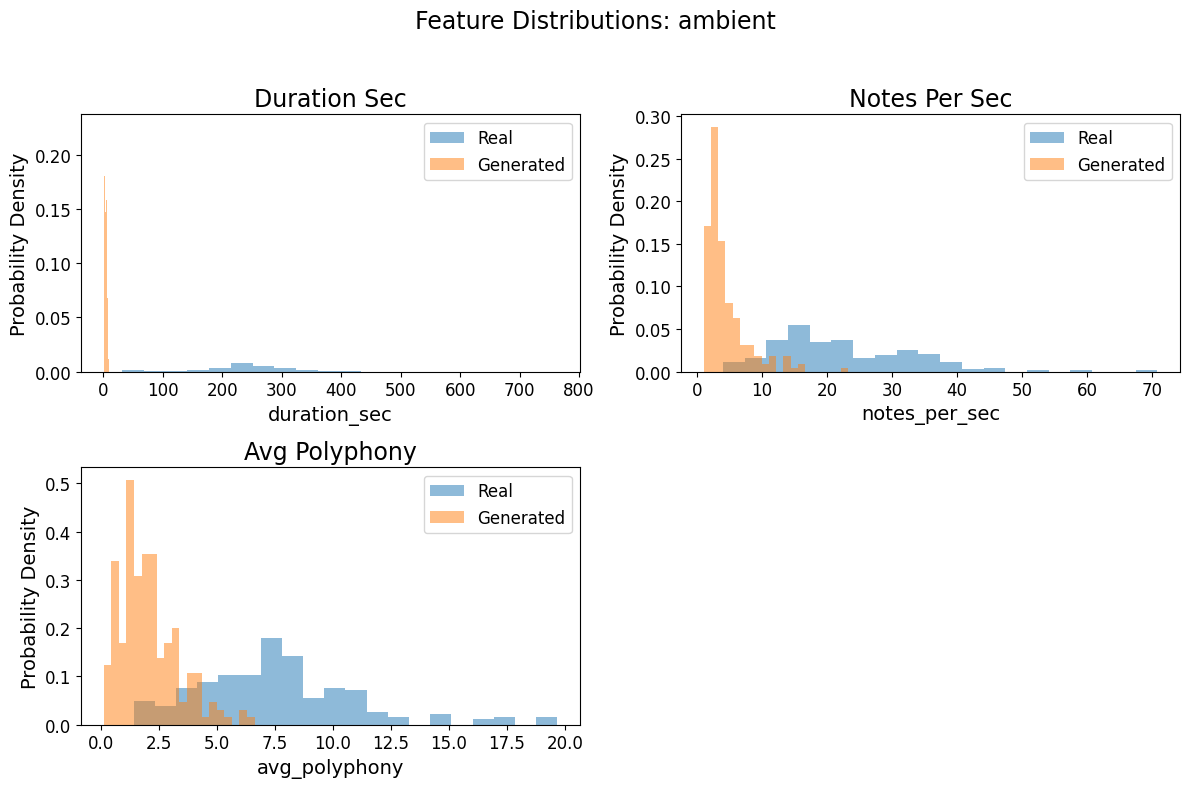


=== Processing Genre: classical ===
Using 200 real 'classical' examples out of 272 available.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Kept 200 real, 200 generated after NaN filtering.
=> classical: KL Divergence = 1.8717
=> classical: Frechet Distance = 24.1486


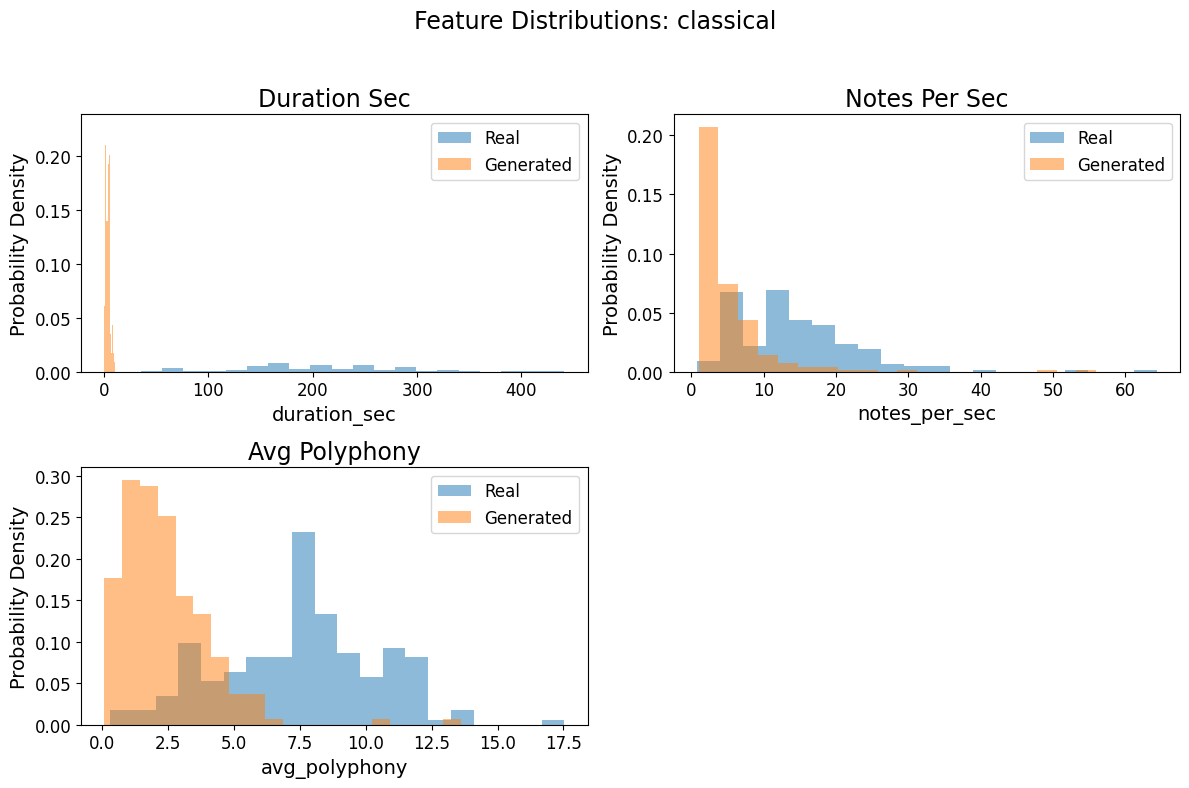


=== Processing Genre: electronic ===
Using 200 real 'electronic' examples out of 1506 available.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Kept 200 real, 200 generated after NaN filtering.
=> electronic: KL Divergence = 3.8678
=> electronic: Frechet Distance = 31.5336


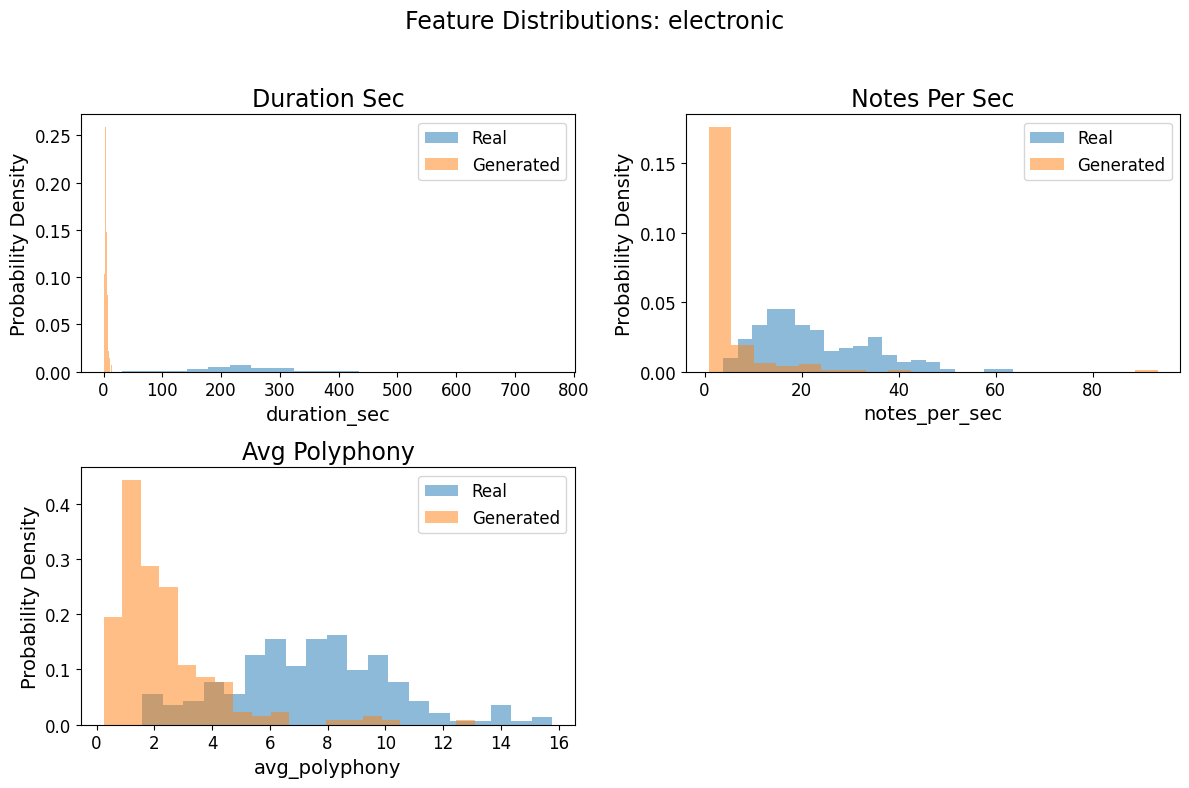


=== Processing Genre: pop ===
Using 200 real 'pop' examples out of 1626 available.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Kept 200 real, 200 generated after NaN filtering.
=> pop: KL Divergence = 6.9404
=> pop: Frechet Distance = 32.2129


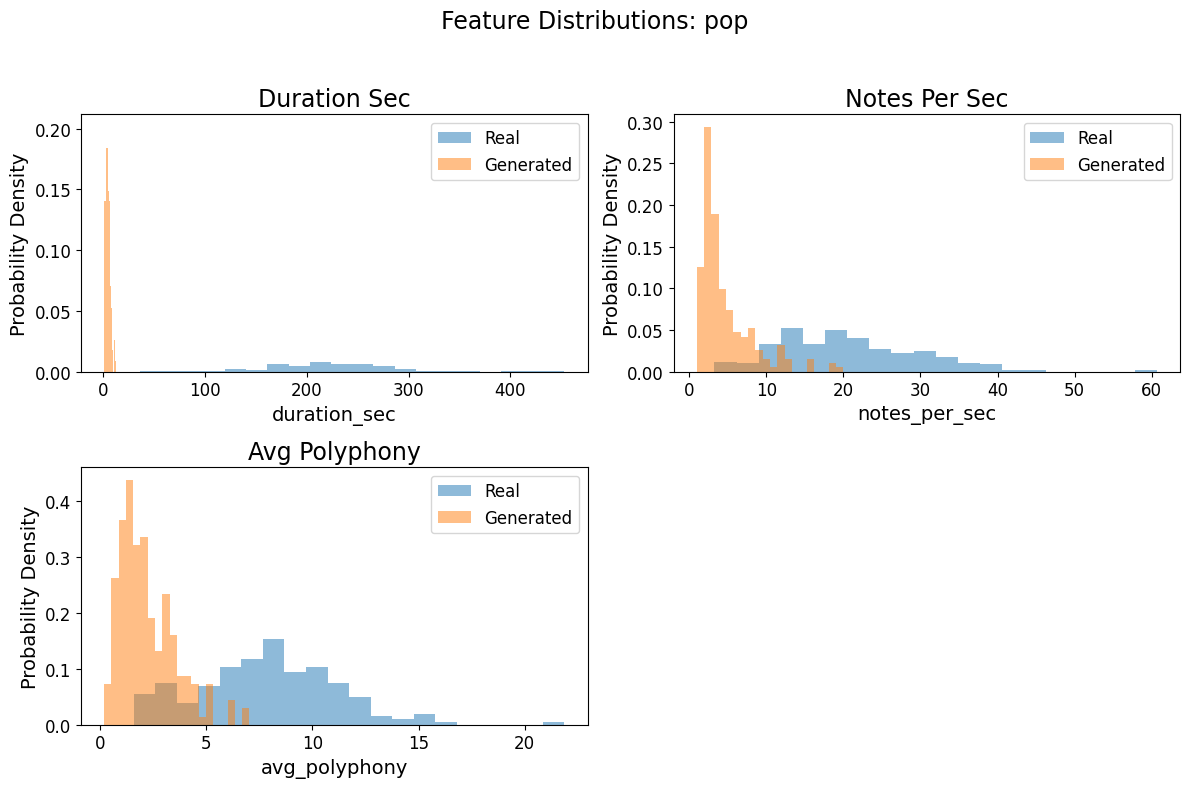


=== Processing Genre: rock ===
Using 200 real 'rock' examples out of 650 available.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Kept 200 real, 200 generated after NaN filtering.
=> rock: KL Divergence = 6.6371
=> rock: Frechet Distance = 32.9339


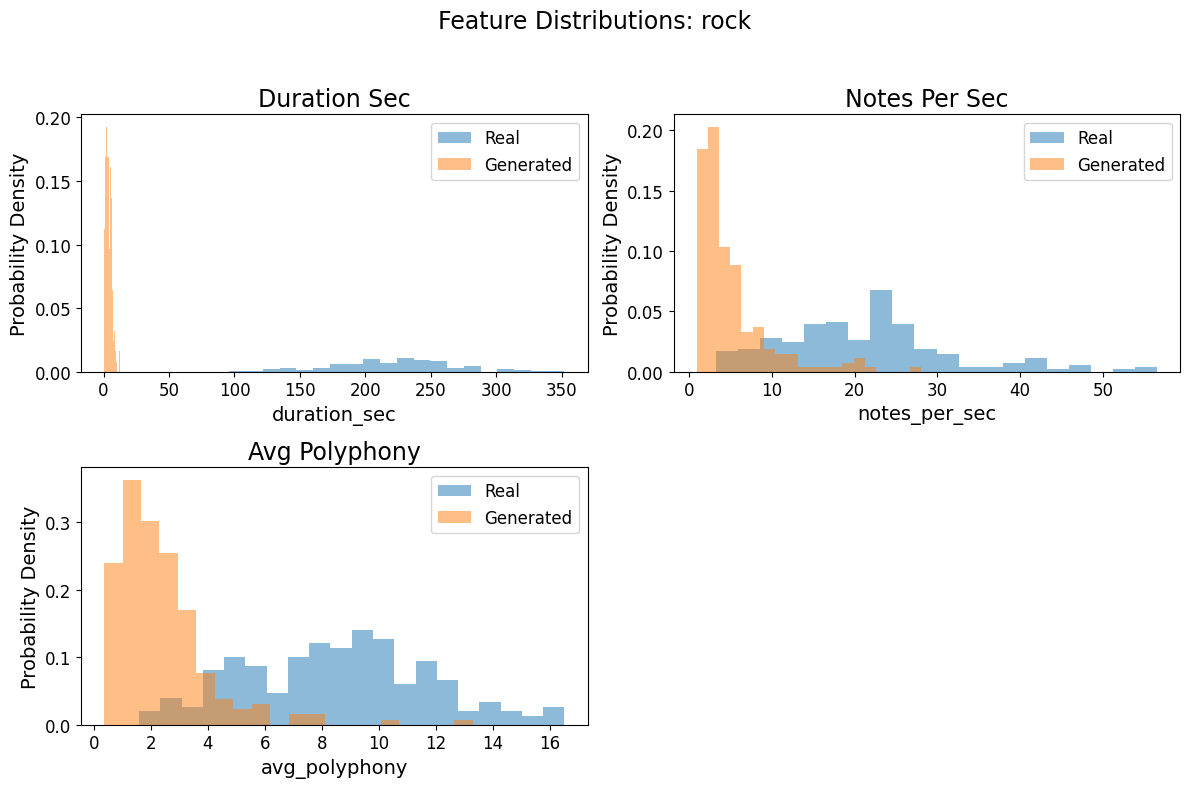


=== Processing Genre: soundtrack ===
Using 200 real 'soundtrack' examples out of 272 available.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Kept 200 real, 200 generated after NaN filtering.
=> soundtrack: KL Divergence = 4.1107
=> soundtrack: Frechet Distance = 25.0375


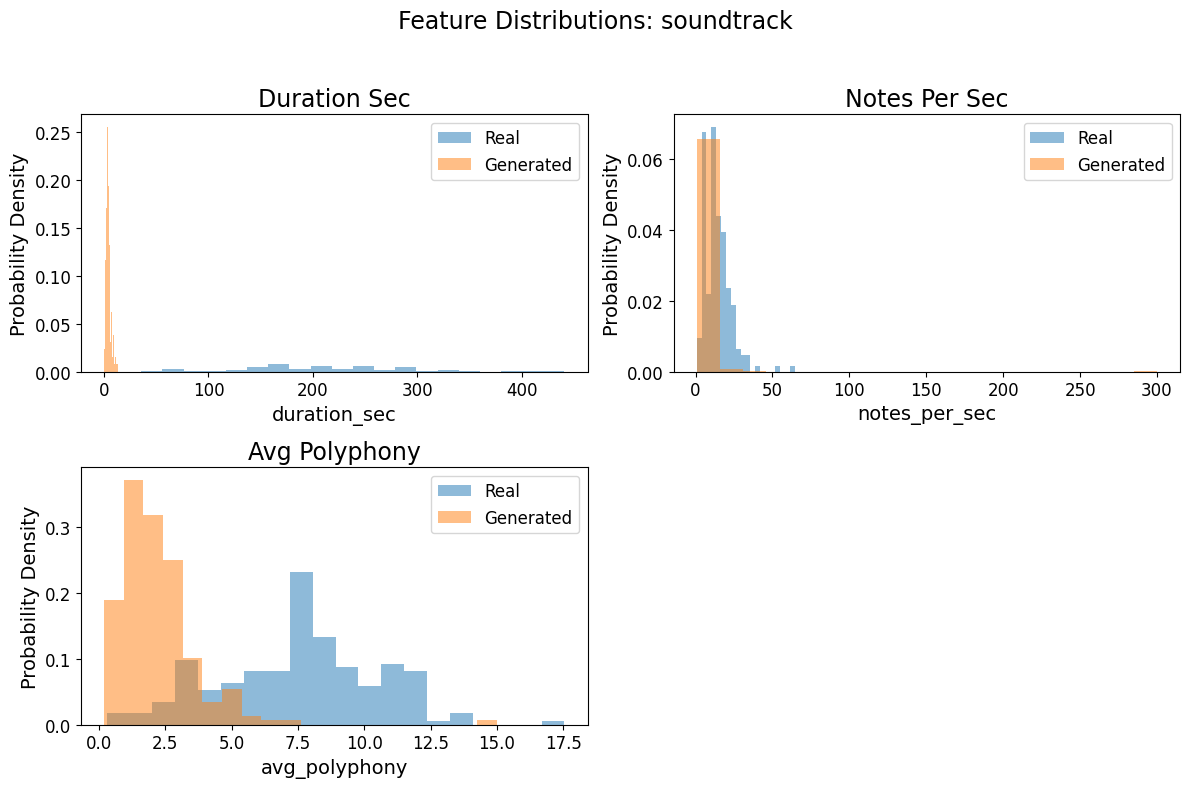

Computing cross-genre Frechet distance matrix...


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI

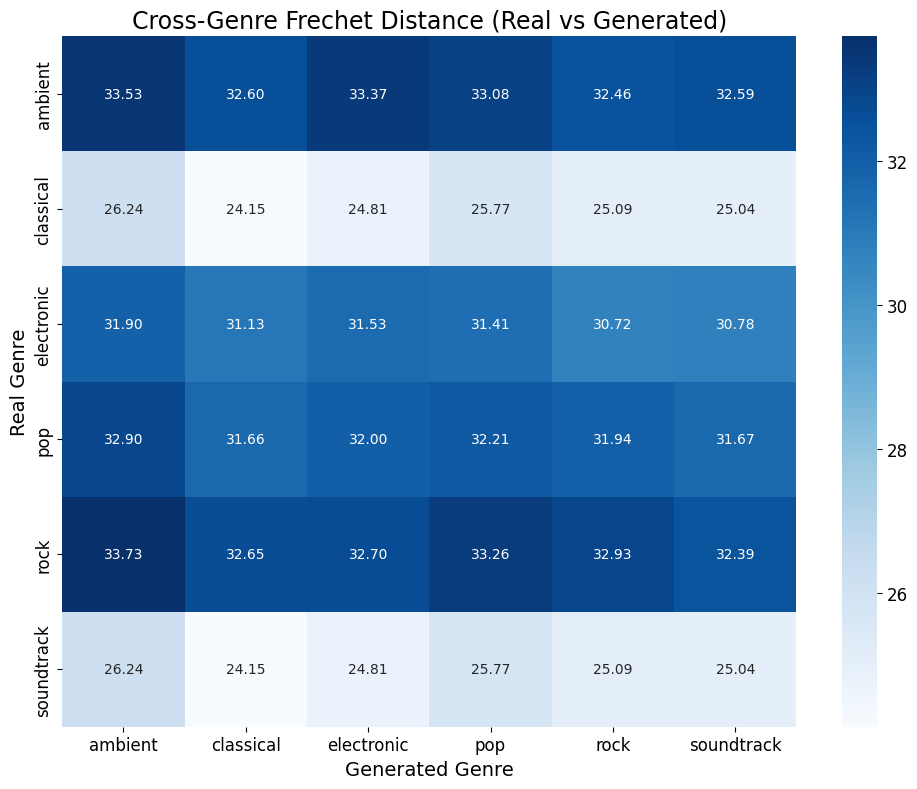

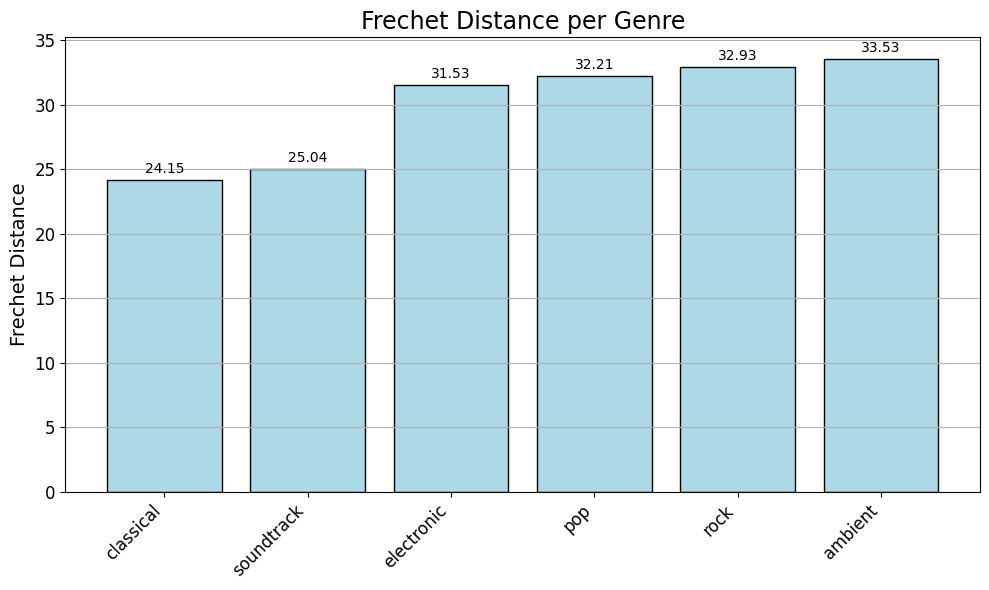

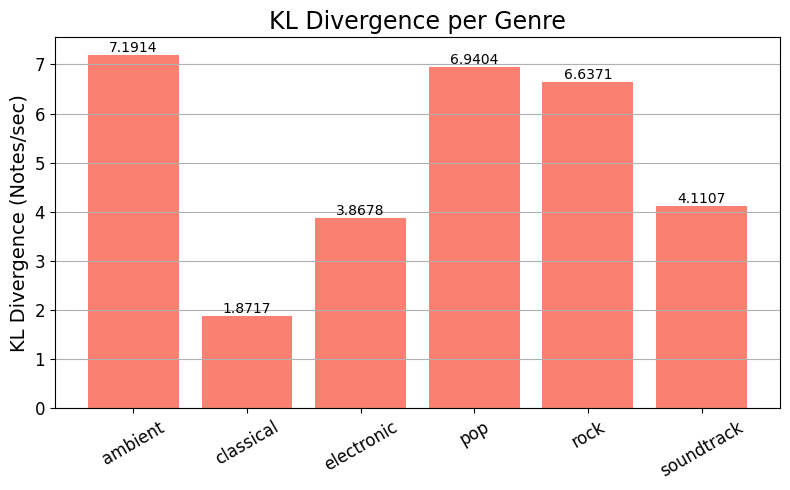

In [40]:
# Evaluate genres
filtered_genres = evaluate_genres(
    dictionary=dictionary,
    transformer=transformer2,
    features_to_plot=["duration_sec", "notes_per_sec", "avg_polyphony"],
    df=df_training_global,
    base_dir=base_dir,
    regenerate=False,         # change to True if you want to overwrite existing MIDIs
    max_samples=200,           # number of real samples to compare per genre
)

In [41]:
def visualize_genre_embeddings_3d(dictionary, transformer, genres):
    """
    Visualizes 3D PCA projection of genre token embeddings from a trained Transformer model,
    and prints the variance explained by each principal component.
    """
    embedding_weights = transformer.model.net.token_emb.emb.weight.detach().cpu()

    genre_tokens = [f"GENRE_{g.upper()}" for g in genres]
    genre_ids = [dictionary.wtd[tok] for tok in genre_tokens if tok in dictionary.wtd]

    vectors = embedding_weights[genre_ids].numpy()

    pca = PCA(n_components=3)
    vectors_3d = pca.fit_transform(vectors)
    var_explained = pca.explained_variance_ratio_ * 100

    print("Explained Variance by PCA Components:")
    for i, var in enumerate(var_explained):
        print(f"  PC{i+1}: {var:.2f}%")

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*vectors_3d.T, color='orchid', s=50)

    for genre, (x, y, z) in zip(genres, vectors_3d):
        ax.text(x, y, z, genre, fontsize=8, ha='center', va='center')

    ax.set_title("3D Genre Token Embeddings (PCA Projection)")
    ax.set_xlabel(f"PC 1 ({var_explained[0]:.1f}%)")
    ax.set_ylabel(f"PC 2 ({var_explained[1]:.1f}%)")
    ax.set_zlabel(f"PC 3 ({var_explained[2]:.1f}%)")

    fig.subplots_adjust(left=0.05, right=0.6, bottom=0.05, top=0.9)
    plt.show()


Explained Variance by PCA Components:
  PC1: 22.78%
  PC2: 21.73%
  PC3: 20.17%


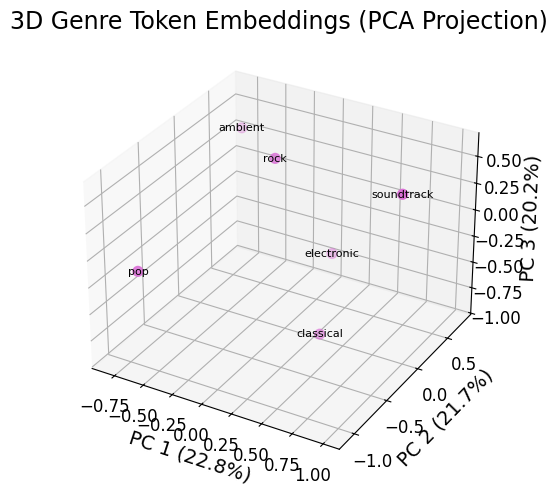

In [42]:
visualize_genre_embeddings_3d(dictionary, transformer2, filtered_genres)

## **Results Interpretation and Analysis**

The baseline Transformer model was evaluated by generating six classical music samples and comparing their musical features to six real classical MIDI files. Feature extraction focused on three key metrics: total duration, number of notes, and note density (notes per second).

The generated samples exhibited much shorter durations and substantially lower note counts compared to real classical pieces. While the real MIDIs typically contained thousands of notes across multi-minute durations, the generated samples were shorter (around 30 seconds on average) and had fewer than 50 notes each.

The overlaid histogram of note densities visually reinforced this discrepancy. Real samples displayed a wider spread, with densities reaching as high as 60 notes per second, whereas the generated samples clustered around very low densities (below 5 notes/sec).

Quantitatively, the Kullback-Leibler (KL) divergence between the real and generated note density distributions was measured at **10.26**, indicating a significant mismatch between the generated and real distributions.

**Strengths:**
- The model was able to produce coherent, playable sequences and recognized the basic structure of classical music tokenization.
- Genre-conditioning worked as intended: the generated outputs were musically plausible and relevant to the "classical" tag.

**Weaknesses:**
- The generated samples failed to match the complexity and richness of real classical pieces.
- Note density and total length were significantly lower, suggesting the model struggled with long-term sequence planning.
- High KL divergence confirmed that the statistical structure of real classical music was not adequately captured.

**Improvement Directions:**
- Increase the output sequence length during generation (e.g., from 60 tokens to 200–300 tokens).
- Fine-tune sampling temperature or use nucleus (top-p) sampling to diversify outputs.
- Train on longer sequences during model training to better model long-term musical structures.
- Consider rebalancing the training dataset to prioritize longer and denser sequences.

## **Sample Outputs!**

Showcases example outputs generated by the Transformer model and their audio previews.

In [43]:
if USE_COLAB:
    # Copy the audio folder from Drive to Colab session only if it isn't already present
    if not audio_local_dir.exists():
        print(f"Copying audio folder from\n  {audio_drive_dir}\nto\n  {audio_local_dir}…")
        shutil.copytree(audio_drive_dir, audio_local_dir)
        print("✅ Copied audio folder.")
    else:
        print("ℹ️ Audio folder already exists in session.")

else:
    # Local runtime: just point to the existing folder
    audio_local_dir = audio_drive_dir  # already under base_dir
    print(f"Using local audio folder at: {audio_local_dir}")

Copying audio folder from
  /content/drive/MyDrive/ac209b_project/audio
to
  /content/audio…
✅ Copied audio folder.


In [44]:
Audio("audio/pop.mp3")

In [45]:
Audio("audio/electronic.mp3")

In [46]:
Audio("audio/rock.mp3")

In [47]:
Audio("audio/soundtrack.mp3")

In [48]:
Audio("audio/ambient.mp3")

In [49]:
Audio("audio/classical.mp3")

## **Final Model Pipeline Setup**

This section outlines the planned pipeline for the final model, building upon the baseline system developed so far.

#### **Data Preprocessing**
- Begin with the cleaned and filtered MIDI dataset, where each file is verified and linked correctly.
- Tokenize each MIDI using a custom tokenizer that encodes quantized time shifts (0.05s resolution), note pitches, and genre tags.
- Ensure that genre labels are consistently formatted and available for all training examples.

#### **Vocabulary Construction**
- Use the existing vocabulary mapping (word-to-token and token-to-word dictionaries) built from the dataset.
- Retain genre tokens as special tokens to enable conditional generation based on musical style.
- Clamp all generated token indices during training to stay within the valid vocabulary range.

#### **Model Architecture**
- Train a decoder-only Transformer model wrapped in an AutoregressiveWrapper.
- Input sequences are conditioned with a genre token prepended at the start.
- Explore enhanced positional encodings such as Rotary Position Embeddings to better capture longer-term dependencies.


#### **Training Strategy**
- Optimize the model using the Adam optimizer and cross-entropy loss.
- Apply gradient accumulation to stabilize training when using small batches.
- Monitor training loss across epochs and clamp token values during training.
- Plan to implement early stopping criteria based on validation loss when scaling up.

#### **Generation and Sampling**
- Generate token sequences using temperature-controlled sampling.
- Experiment with nucleus (top-p) or top-k sampling strategies to improve diversity and musical creativity.
- Generate both short (1-minute) and longer (3–5 minute) pieces to assess temporal coherence.

#### **Evaluation Metrics**
The evaluation will assess both the low-level musical structure and high-level musical quality of generated samples.

- **Feature Matching:** Extract simple features from generated and real MIDI files, including total duration (seconds), number of notes, and note density (notes per second), and compare their distributions using histograms, KDE plots, and KL divergence between real and generated feature distributions.

-  **Musicological Metrics:** Analyze pitch class histograms to assess melodic variety and harmonic structure, compute tonal centroid (Tonnetz) distances to measure harmonic similarity between real and generated samples, and evaluate rhythmic consistency through note onset distributions and temporal structure analysis.

- **Human Listening Evaluation:** Gather subjective ratings on realism, genre match, musical pleasantness. Aggregate scores for additional qualitative evaluation.

#### **Assumptions and Tuning Considerations**
- Assume all MIDI files are clean, quantized, and genre-tagged.
- Initial hyperparameters: learning rate $1e^{-4}$, batch size of 8–16, sequence length up to 512 tokens.
- Hyperparameter tuning will focus on Transformer depth, dropout rate, and sampling strategies based on early validation results.


---